<strong><b><font size="5">Time Series Analysis and Forecasting in Python</font></b></strong>

# Time Series
- A time series is a sequential set of data points, measured typically over successive times. 
- It is mathematically defined as a set of vectors x(t), t = 0,1,2,... where t represents the time elapsed. 
- The variable x(t) is treated as a random variable. 
- The measurements taken during an event in a time series are arranged in a proper chronological order. 
- A time series containing records of a single variable is termed as univariate, and more than one variable a multivariate. 

# Importing Libraries for time series forecasting

In [28]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')

import pandas as pd
pd.set_option('display.expand_frame_repr', False)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARMA, ARIMA
# from pyramid.arima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet

from math import sqrt

import matplotlib
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'
import seaborn as sns

from random import random

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

# Importing data
- Dataset: International airline passengers
- Unit: Thousands

In [2]:
df = pd.read_csv('hourly_load_2016.csv',header=None)

In [3]:
df.columns = ['time','hourly_load']

In [4]:
df.head(3)

time  hourly_load
0       1/1/2016   1311693.43
1  1/1/2016 1:00   1240583.19
2  1/1/2016 2:00   1185502.49

In [5]:
df.describe()

hourly_load
count  5.112000e+03
mean   1.469800e+06
std    3.314772e+05
min    6.682374e+05
25%    1.243815e+06
50%    1.433399e+06
75%    1.702519e+06
max    2.503796e+06

In [6]:
print('Time period start: {}\nTime period end: {}'.format(df.time.min(),df.time.max()))

Time period start: 1/1/2016
Time period end: 7/9/2016 9:00


In [7]:
df.columns

Index(['time', 'hourly_load'], dtype='object')

In [8]:
df.shape

(5112, 2)

# Data Preprocessing and Visualization

__Converting to datetime format:__

In [9]:
df['time'] = pd.to_datetime(df['time'], infer_datetime_format=True)
df.head()

# df['time'] = pd.to_datetime(df['time'], format='%Y-%m %H:%M:%S')

time  hourly_load
0 2016-01-01 00:00:00   1311693.43
1 2016-01-01 01:00:00   1240583.19
2 2016-01-01 02:00:00   1185502.49
3 2016-01-01 03:00:00   1145963.66
4 2016-01-01 04:00:00   1123874.26

__Setting index as the datetime column for easier manipulations:__

In [22]:
y = df.set_index('time')[:744]

In [23]:
y.index

DatetimeIndex(['2016-01-01 00:00:00', '2016-01-01 01:00:00', '2016-01-01 02:00:00', '2016-01-01 03:00:00', '2016-01-01 04:00:00', '2016-01-01 05:00:00', '2016-01-01 06:00:00', '2016-01-01 07:00:00', '2016-01-01 08:00:00', '2016-01-01 09:00:00',
               ...
               '2016-01-31 14:00:00', '2016-01-31 15:00:00', '2016-01-31 16:00:00', '2016-01-31 17:00:00', '2016-01-31 18:00:00', '2016-01-31 19:00:00', '2016-01-31 20:00:00', '2016-01-31 21:00:00', '2016-01-31 22:00:00', '2016-01-31 23:00:00'], dtype='datetime64[ns]', name='time', length=744, freq=None)

In [24]:
y.isnull().sum()

hourly_load    0
dtype: int64

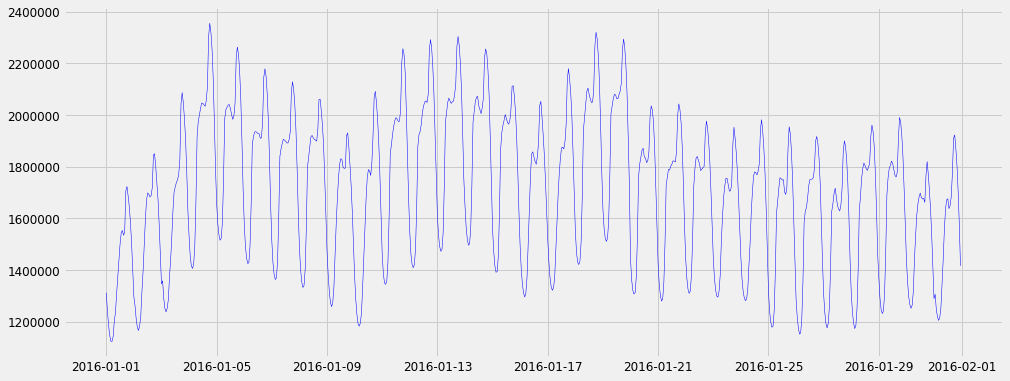

In [46]:
plt.figure(figsize=(15, 6))
plt.plot(y.index, y.values, color = 'blue', linewidth = 0.5)
plt.show()

__Reviewing plots of the density of observations can provide further insight into the structure of the data:__
- The distribution is not perfectly Gaussian (normal distribution).
- The distribution is left shifted.
- Transformations might be useful prior to modelling.

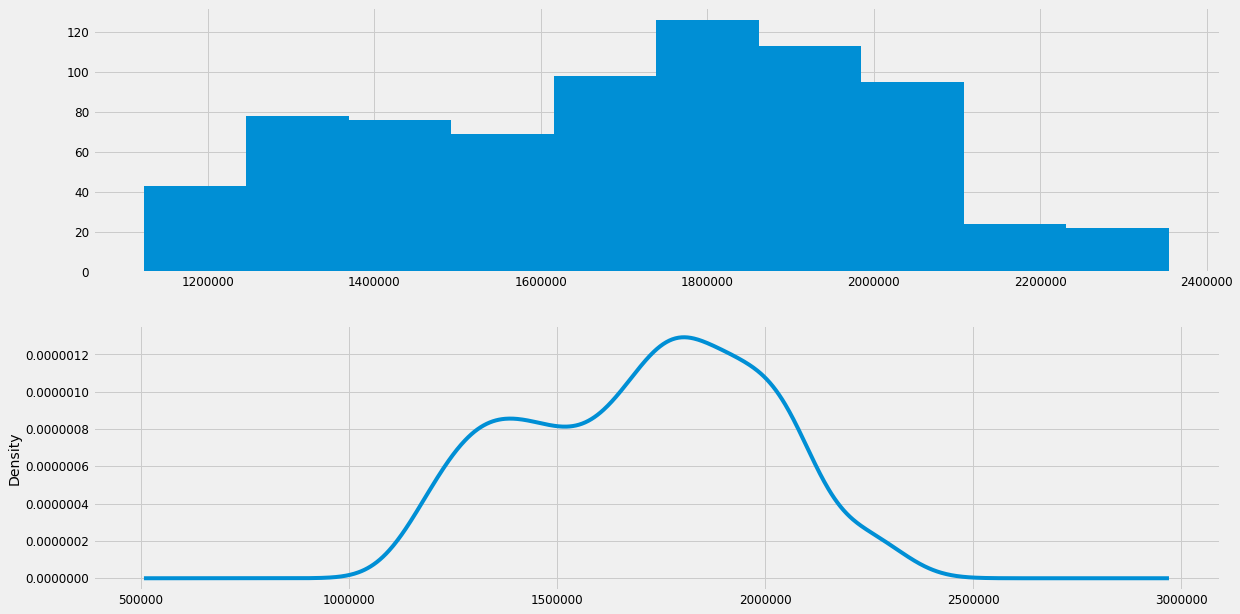

In [47]:
from pandas import Series
from matplotlib import pyplot
pyplot.figure(1)
pyplot.subplot(211)
y.hourly_load.hist()
pyplot.subplot(212)
y.hourly_load.plot(kind='kde')
pyplot.show()

__Box and Whisker Plots:__
- Median values across years confirms an upwards trend
- Steady increase in the spread, or middle 50% of the data (boxes) over time
- A model considering seasonality might work well

Int64Index([53, 53, 53, 53, 53, 53, 53, 53, 53, 53,
            ...
             4,  4,  4,  4,  4,  4,  4,  4,  4,  4], dtype='int64', name='time', length=744)


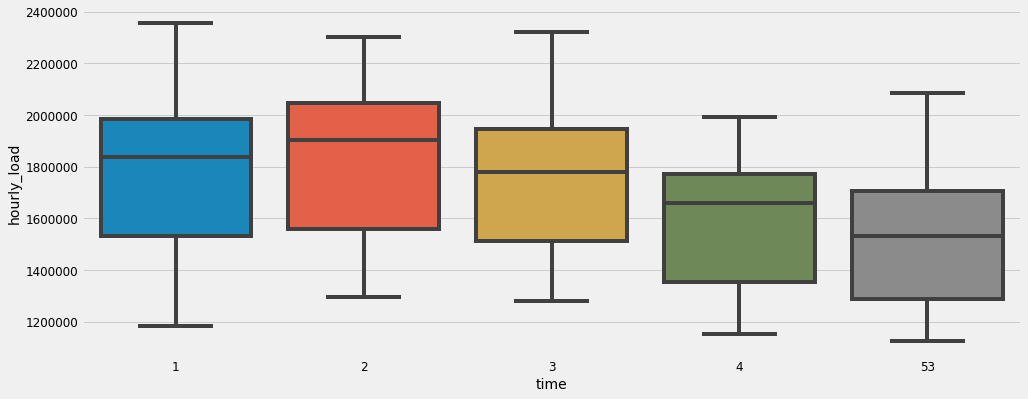

In [48]:
fig, ax = plt.subplots(figsize=(15,6))
sns.boxplot(y.hourly_load.index.week, y.hourly_load, ax=ax)
print(y.hourly_load.index.week)

__Decomposing using statsmodel:__
- We can use statsmodels to perform a decomposition of this time series. 
- The decomposition of time series is a statistical task that deconstructs a time series into several components, each representing one of the underlying categories of patterns. 
- With statsmodels we will be able to see the trend, seasonal, and residual components of our data.

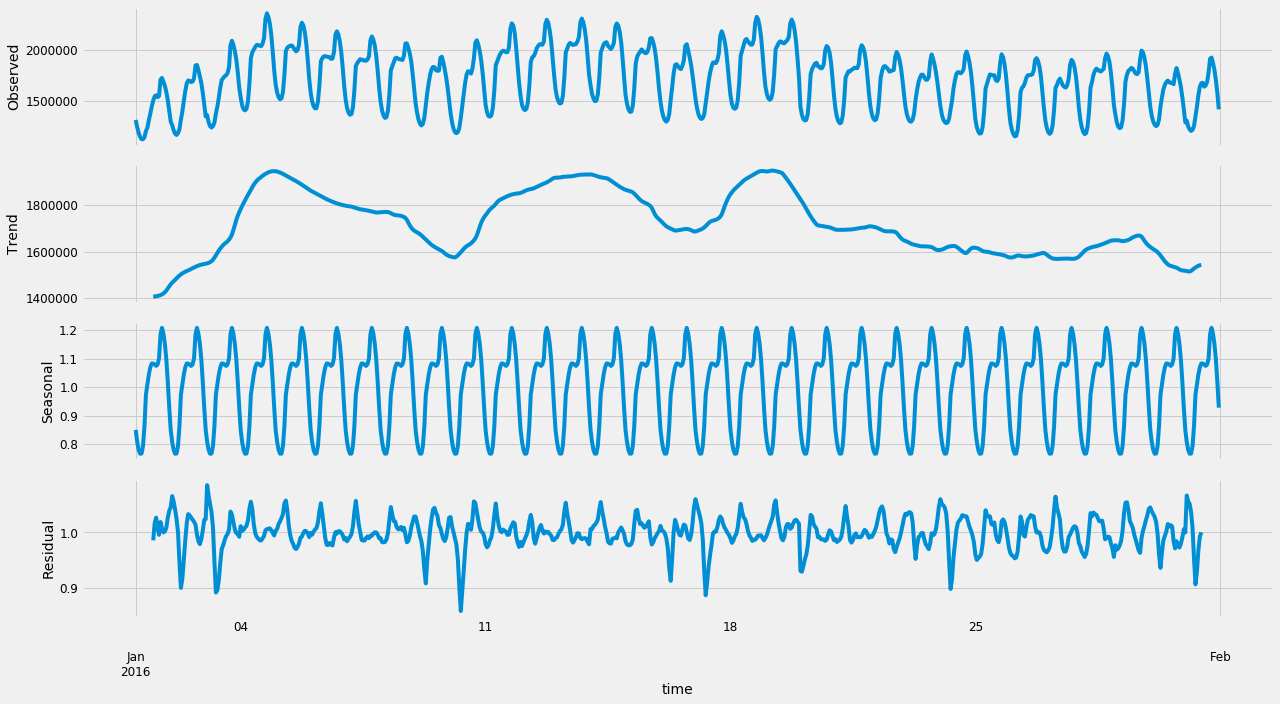

In [51]:
from pylab import rcParams
pd.plotting.register_matplotlib_converters()
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(y, model='multiplicative')
decomposition.plot()

plt.show()

## Stationarity
- A Time Series is said to be stationary if its statistical properties such as mean, variance remain constant over time.
- Most of the Time Series models work on the assumption that the TS is stationary. Major reason for this is that there are many ways in which a series can be non-stationary, but only one way for stationarity.
- Intuitively, we can say that if a Time Series has a particular behaviour over time, there is a very high probability that it will follow the same in the future. 
- Also, the theories related to stationary series are more mature and easier to implement as compared to non-stationary series.

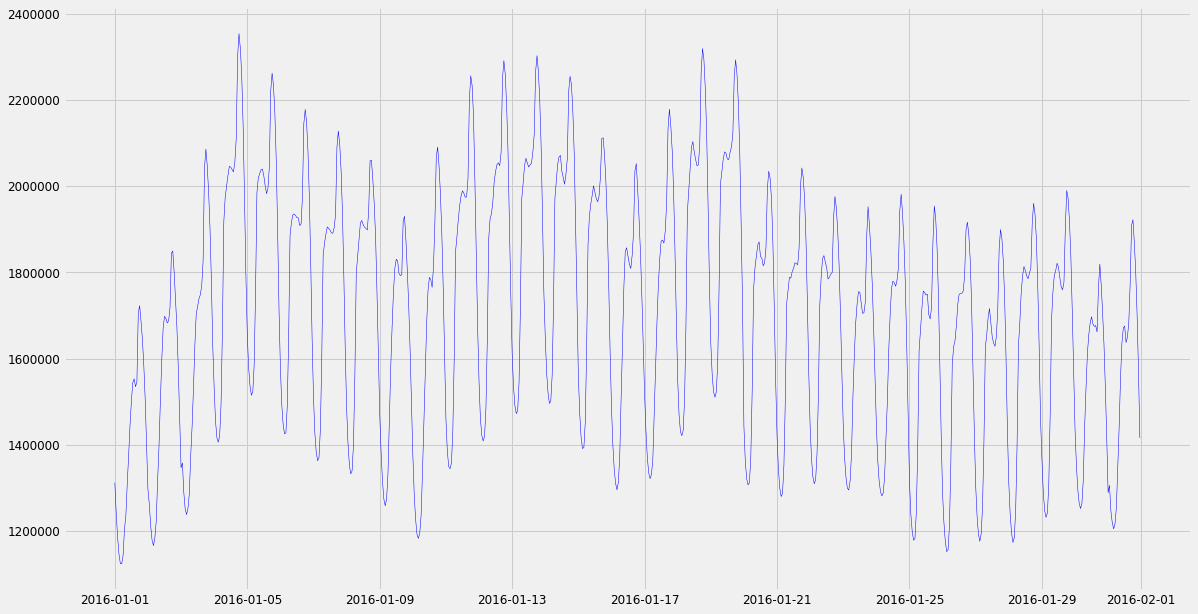

In [50]:
plt.plot(y, color='blue', linewidth = 0.5)

__We can check stationarity using the following:__

- __ACF and PACF plots__: If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- __Plotting Rolling Statistics__: We can plot the moving average or moving variance and see if it varies with time. Moving average/variance is for any instant ‘t’, the average/variance of the last year, i.e. last 12 months.
- __Augmented Dickey-Fuller Test:__ This is one of the statistical tests for checking stationarity. Here the null hypothesis is that the TS is non-stationary. The test results comprise of a Test Statistic and some Critical Values for difference confidence levels. If the ‘Test Statistic’ is less than the ‘Critical Value’, we can reject the null hypothesis and say that the series is stationary. Refer this article for details.

### ACF and PACF plots

- Let's review the Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots
- If the time series is stationary, the ACF/PACF plots will show a __quick drop-off in correlation__ after a small amount of lag between points.
- This data is non-stationary as a high number of previous observations are correlated with future values.
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- The partial autocorrelation at lag k is the correlation that results after removing the effect of any correlations due to the terms at shorter lags.

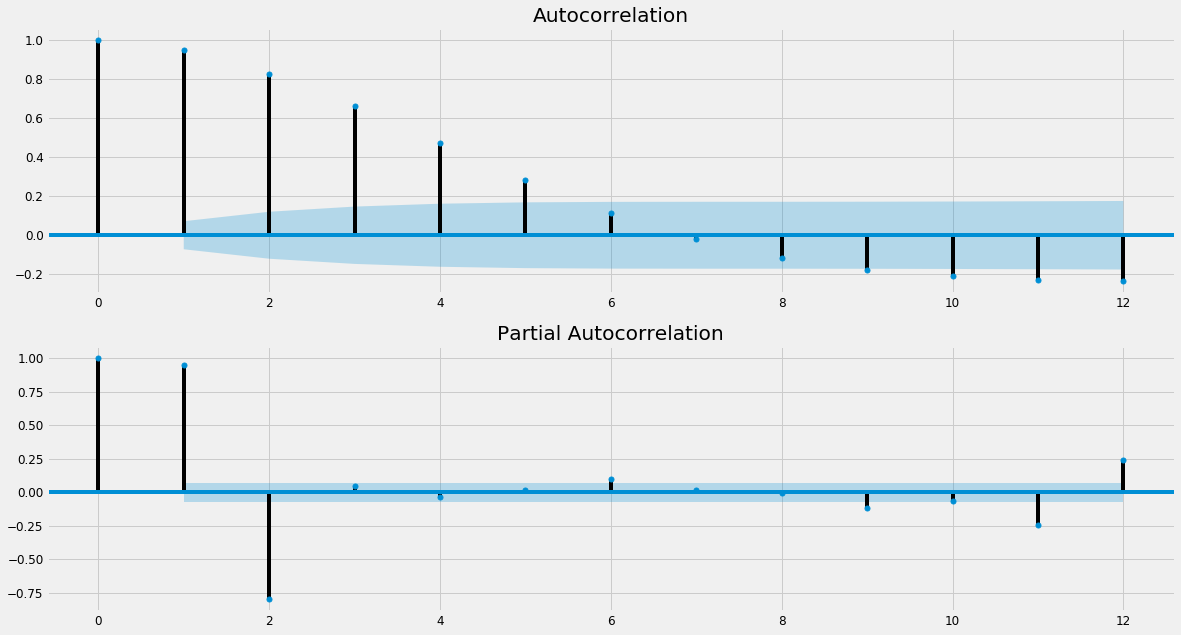

In [40]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

pyplot.figure()
pyplot.subplot(211)
plot_acf(y.hourly_load, ax=pyplot.gca(), lags = 12)
pyplot.subplot(212)
plot_pacf(y.hourly_load, ax=pyplot.gca(), lags = 12)
pyplot.show()

### Plotting Rolling Statistics
- We observe that the rolling mean and Standard deviation are not constant with respect to time (increasing trend)
- The time series is hence not stationary

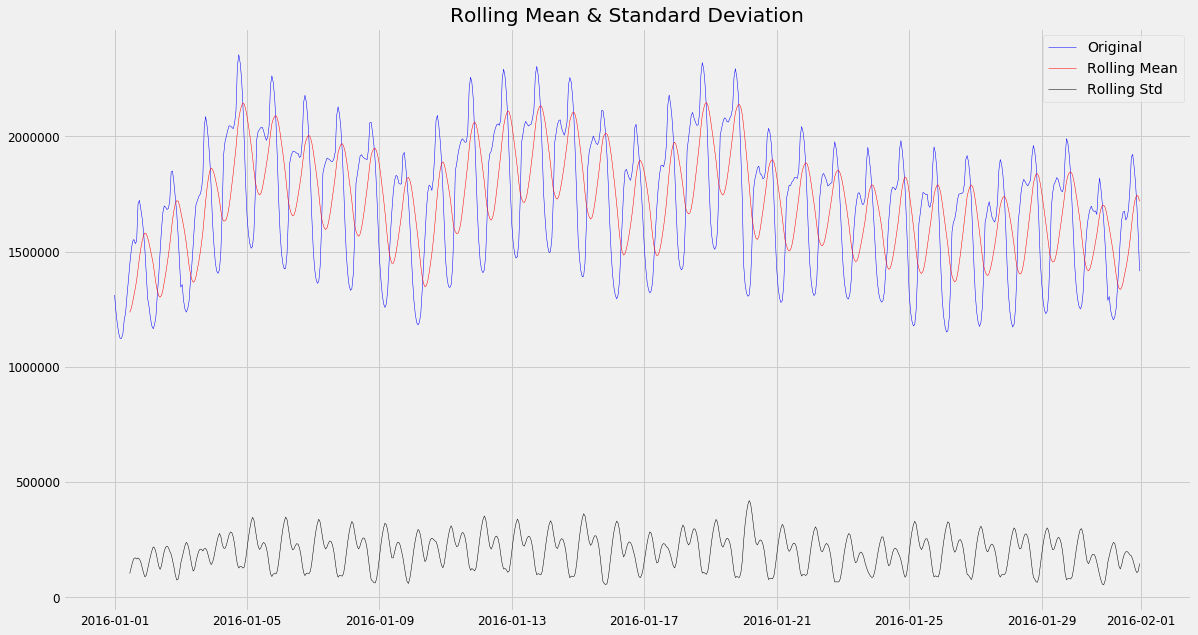

In [52]:
#Determing rolling statistics
rolmean = y.rolling(12).mean()
rolstd = y.rolling(12).std()

#Plot rolling statistics:
orig = plt.plot(y, color='blue',label='Original', linewidth = 0.5)
mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth = 0.5)
std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth = 0.5)
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

### Augmented Dickey-Fuller Test
- The intuition behind the test is that if the series is integrated then the lagged level of the series y(t-1)  will provide no relevant information in predicting the change in y(t).
- Null hypothesis: The time series is not stationary
- Rejecting the null hypothesis (i.e. a very low p-value) will indicate staionarity

In [42]:
from statsmodels.tsa.stattools import adfuller

In [43]:
#Perform Dickey-Fuller test:
print ('Results of Dickey-Fuller Test:')
dftest = adfuller(y.hourly_load, autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
    dfoutput['Critical Value (%s)'%key] = value
print (dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                  -1.811962
p-value                          0.374539
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64


In [53]:
def test_stationarity(timeseries):
    
    #Determing rolling statistics
    rolmean = timeseries.rolling(12).mean()
    rolstd = timeseries.rolling(12).std()

    #Plot rolling statistics:
    orig = plt.plot(timeseries, color='blue',label='Original', linewidth = 0.5)
    mean = plt.plot(rolmean, color='red', label='Rolling Mean', linewidth = 0.5)
    std = plt.plot(rolstd, color='black', label = 'Rolling Std', linewidth = 0.5)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

## Making Time Series Stationary
There are 2 major reasons behind non-stationaruty of a TS:

1. __Trend__ – varying mean over time. For eg, in this case we saw that on average, the number of passengers was growing over time.
2. __Seasonality__ – variations at specific time-frames. eg people might have a tendency to buy cars in a particular month because of pay increment or festivals.

### Transformations
- We can apply transformation which penalize higher values more than smaller values. These can be taking a log, square root, cube root, etc. Lets take a log transform here for simplicity:

#### Log Scale Transformation

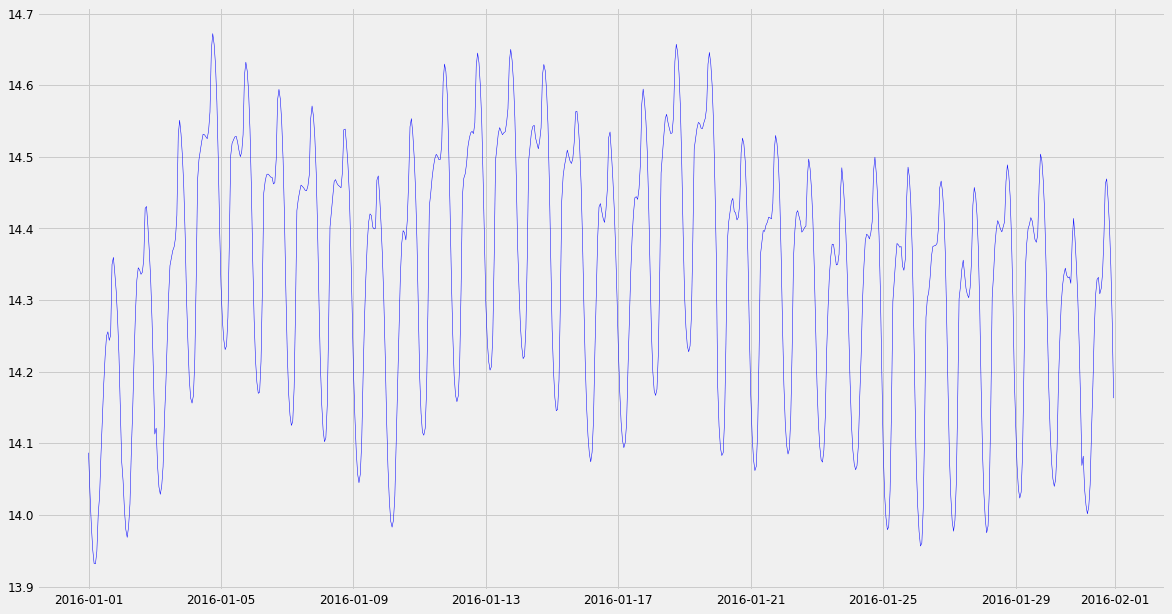

In [54]:
ts_log = np.log(y)
plt.plot(ts_log, linewidth = 0.5, color='blue')

#### Other possible transformations:
- Exponential tranformation
- Box Cox transformation
- Square root transformation

### Techniques to remove Trend - Smoothing
- Smoothing is taking rolling averages over windows of time

#### Moving Average
- We take average of ‘k’ consecutive values depending on the frequency of time series. 
- Here we can take the average over the past 1 year, i.e. last 12 values. 
- A drawback in this particular approach is that the time-period has to be strictly defined. 

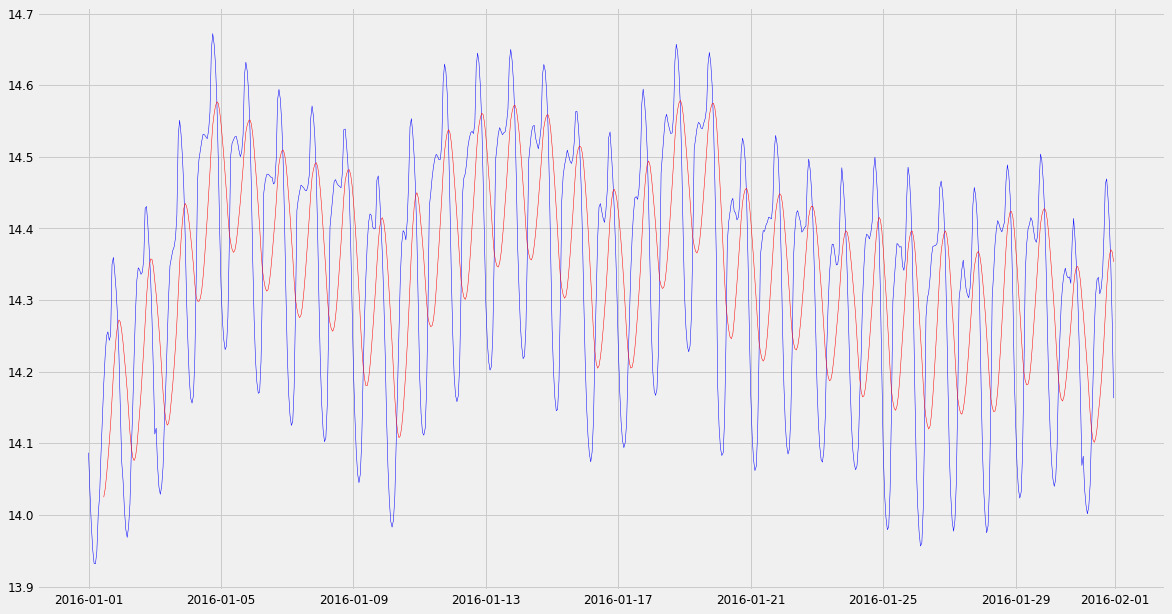

In [55]:
moving_avg = ts_log.rolling(12).mean()
plt.plot(ts_log, color='blue', linewidth = 0.5)
plt.plot(moving_avg, color='red', linewidth = 0.5)

In [56]:
ts_log_moving_avg_diff = ts_log.hourly_load - moving_avg.hourly_load
ts_log_moving_avg_diff.head(12)

time
2016-01-01 00:00:00         NaN
2016-01-01 01:00:00         NaN
2016-01-01 02:00:00         NaN
2016-01-01 03:00:00         NaN
2016-01-01 04:00:00         NaN
2016-01-01 05:00:00         NaN
2016-01-01 06:00:00         NaN
2016-01-01 07:00:00         NaN
2016-01-01 08:00:00         NaN
2016-01-01 09:00:00         NaN
2016-01-01 10:00:00         NaN
2016-01-01 11:00:00    0.158084
Name: hourly_load, dtype: float64

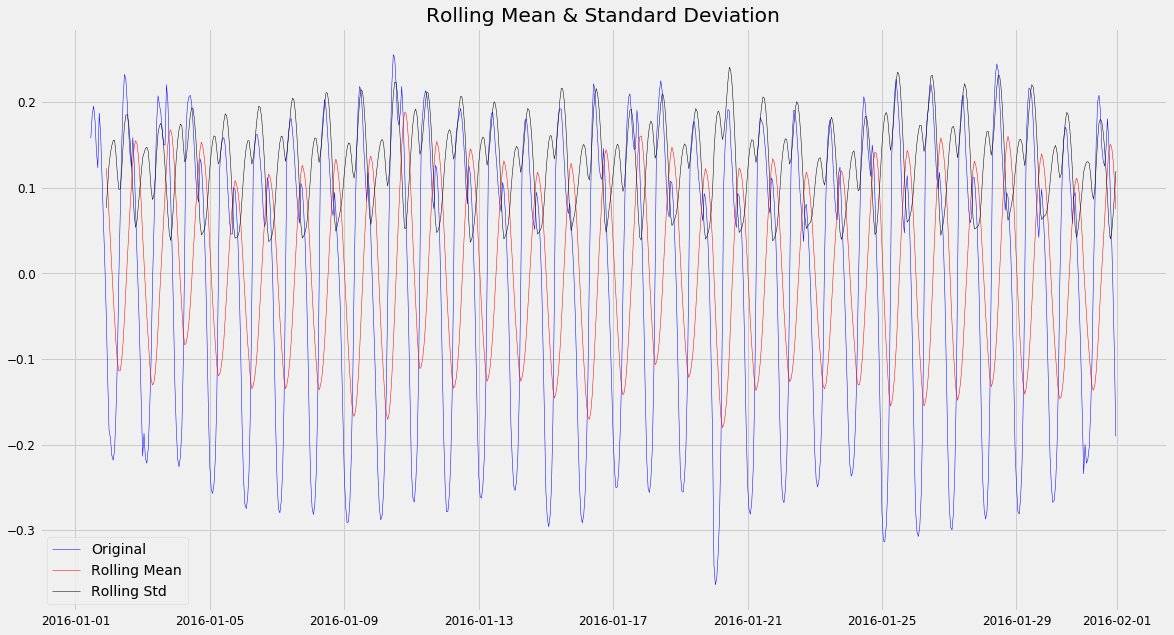

Results of Dickey-Fuller Test:
Test Statistic                  -4.727617
p-value                          0.000075
#Lags Used                      20.000000
Number of Observations Used    712.000000
Critical Value (1%)             -3.439568
Critical Value (5%)             -2.865608
Critical Value (10%)            -2.568936
dtype: float64


In [57]:
ts_log_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_log_moving_avg_diff)

#### Exponentially weighted moving average:
- To overcome the problem of choosing a defined window in moving average, we can use exponential weighted moving average
- We take a ‘weighted moving average’ where more recent values are given a higher weight. 
- There can be many technique for assigning weights. A popular one is exponentially weighted moving average where weights are assigned to all the previous values with a decay factor. 

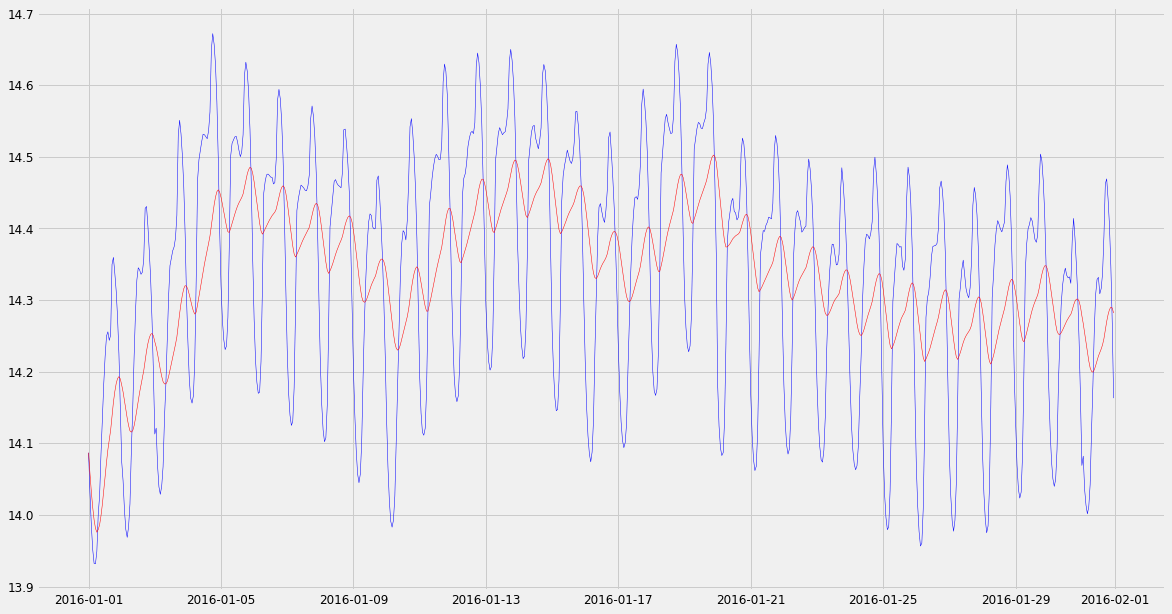

In [58]:
expwighted_avg = ts_log.ewm(halflife=12).mean()
plt.plot(ts_log, color='blue', linewidth = 0.5)
plt.plot(expwighted_avg, color='red', linewidth = 0.5)

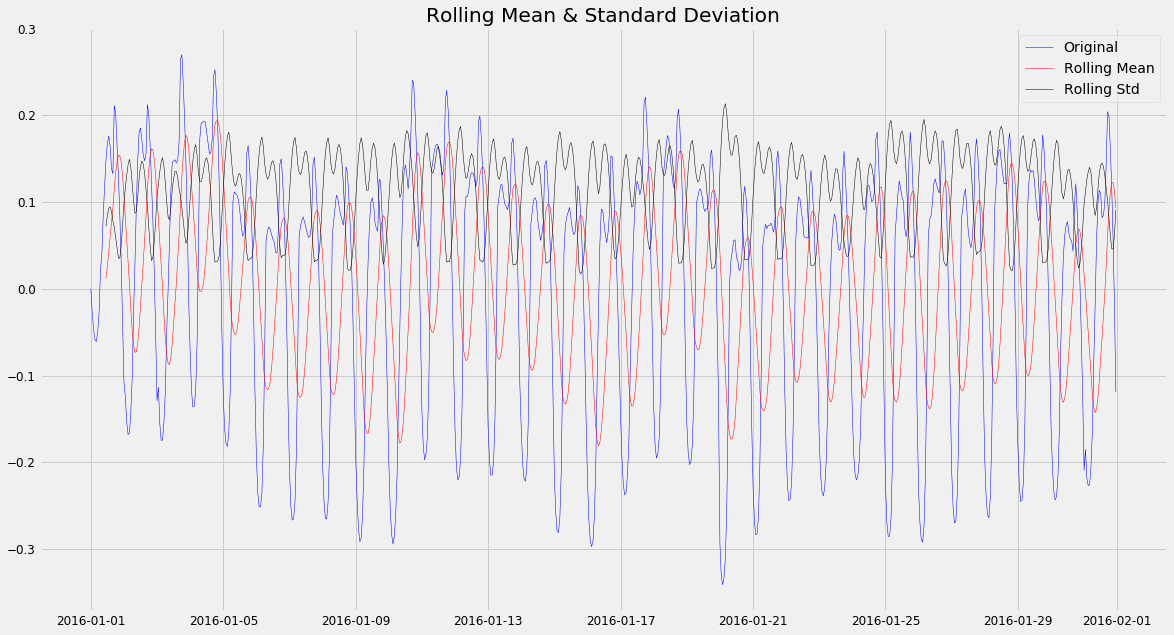

Results of Dickey-Fuller Test:
Test Statistic                  -2.819991
p-value                          0.055474
#Lags Used                      20.000000
Number of Observations Used    723.000000
Critical Value (1%)             -3.439427
Critical Value (5%)             -2.865546
Critical Value (10%)            -2.568903
dtype: float64


In [59]:
ts_log_ewma_diff = ts_log.hourly_load - expwighted_avg.hourly_load
test_stationarity(ts_log_ewma_diff)

### Further Techniques to remove Seasonality and Trend
- The simple trend reduction techniques discussed before don’t work in all cases, particularly the ones with high seasonality. 

#### Differencing
- In this technique, we take the difference of the observation at a particular instant with that at the previous instant. 
- First order differencing in Pandas

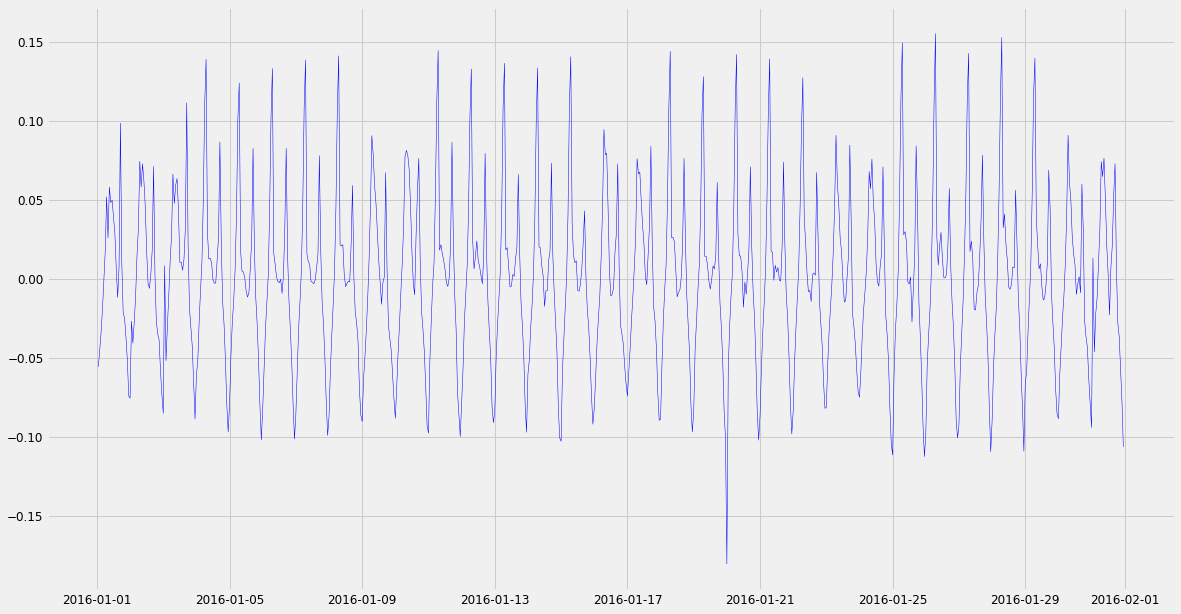

In [60]:
ts_log_diff = ts_log.hourly_load - ts_log.hourly_load.shift()
plt.plot(ts_log_diff, color='blue', linewidth = 0.5)

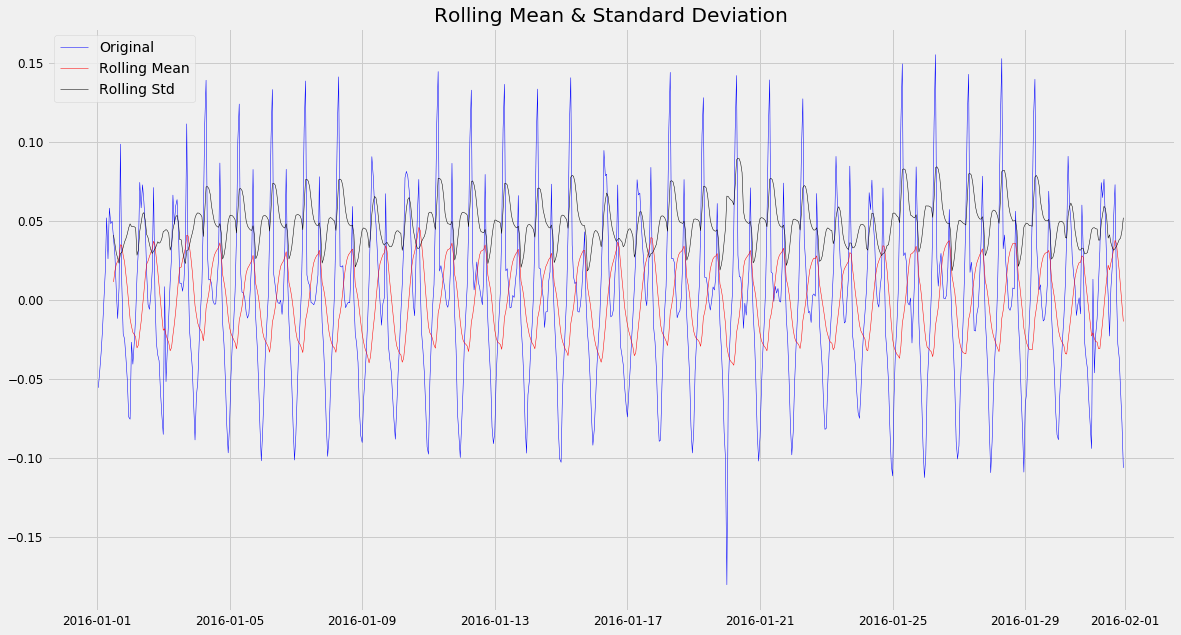

Results of Dickey-Fuller Test:
Test Statistic                -1.659296e+01
p-value                        1.792151e-29
#Lags Used                     2.000000e+01
Number of Observations Used    7.220000e+02
Critical Value (1%)           -3.439440e+00
Critical Value (5%)           -2.865551e+00
Critical Value (10%)          -2.568906e+00
dtype: float64


In [61]:
ts_log_diff.dropna(inplace=True)
test_stationarity(ts_log_diff)

#### Decomposition
- In this approach, both trend and seasonality are modeled separately and the remaining part of the series is returned.

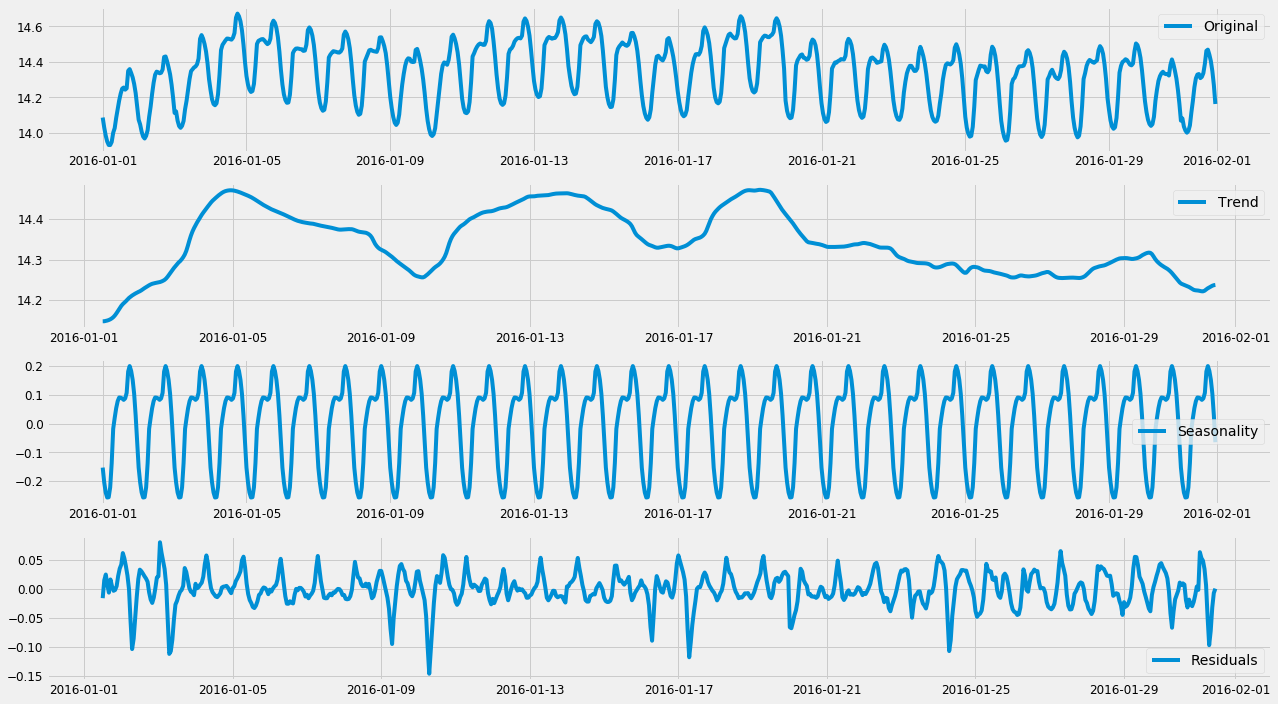

In [62]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

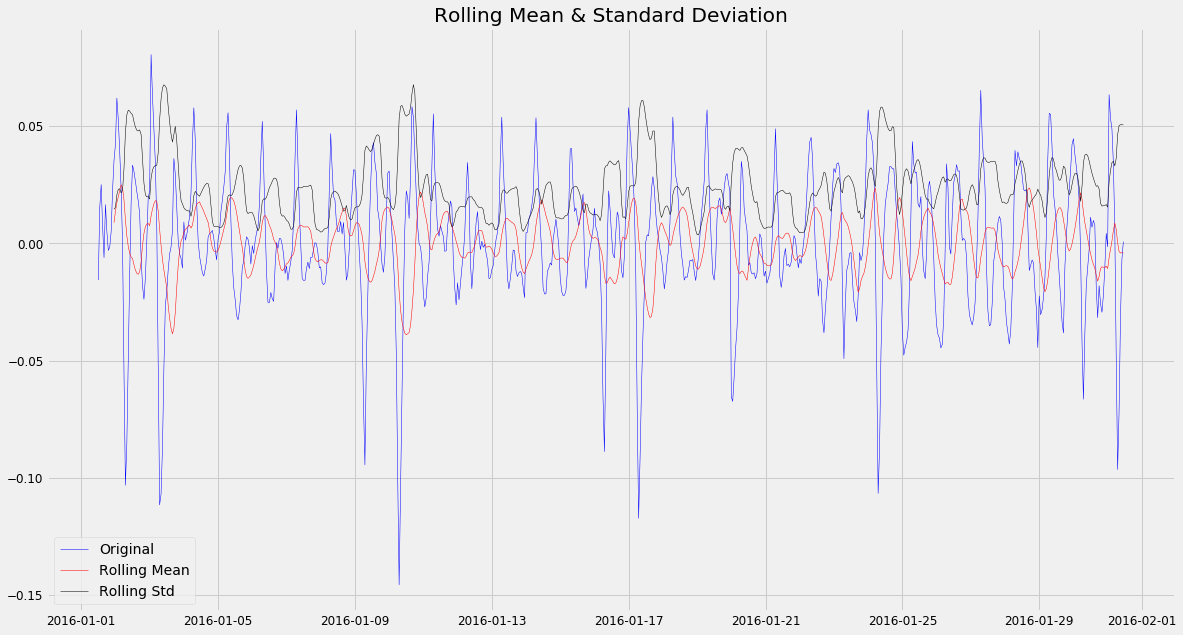

Results of Dickey-Fuller Test:
Test Statistic                -1.009131e+01
p-value                        1.120244e-17
#Lags Used                     1.700000e+01
Number of Observations Used    7.020000e+02
Critical Value (1%)           -3.439700e+00
Critical Value (5%)           -2.865666e+00
Critical Value (10%)          -2.568967e+00
dtype: float64


In [63]:
ts_log_decompose = residual.hourly_load
ts_log_decompose.dropna(inplace=True)
test_stationarity(ts_log_decompose)

# Time Series forecasting
[Statsmodel example notebooks](https://github.com/statsmodels/statsmodels/tree/master/examples/notebooks)

Test MSE: 0.000


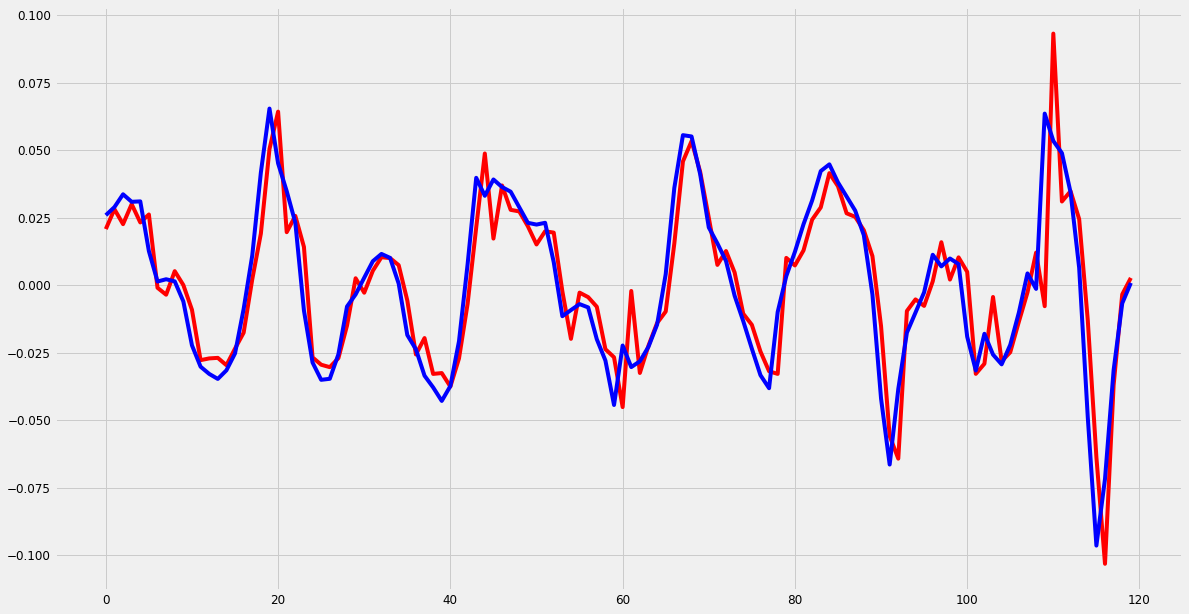

In [64]:
train=ts_log_decompose[:600]
test=ts_log_decompose[600:]
history = [x for x in train]
predictions2 = []
for t in range(len(test)):
    model = ARIMA(history, order=(1,0,4))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions2.append(yhat)
    obs = test[t]
    history.append(obs)
    #print('predicted=%f, expected=%f' % (yhat, obs))
error = mean_squared_error(test, predictions2)
print('Test MSE: %.3f' % error)
# plot
#pyplot.plot(test)
#pyplot.plot(predictions, color='red')
#pyplot.show()
#plt.plot(predictions2)
test2=test.values
plt.plot(predictions2,color='red')
plt.plot(test2,color='blue')
plt.show()

In [ ]:
def 

In [ ]:
def n_day_prediction(n, ):
    train=ts_log_decompose[:600]
    test=ts_log_decompose[600:]
    history = [x for x in train]
    predictions2 = []
    for t in range(len(test)):
        for i in range(n):
            model = ARIMA(history, order=(1,0,4))
            model_fit = model.fit(disp=0)
            output = model_fit.forecast()
            yhat = output[0]
            predictions2.append(yhat)
            obs = test[t]
            history.append(predictions2)
        #print('predicted=%f, expected=%f' % (yhat, obs))
    error = mean_squared_error(test, predictions2)
    print('Test MSE: %.3f' % error)
    # plot
    #pyplot.plot(test)
    #pyplot.plot(predictions, color='red')
    #pyplot.show()
    #plt.plot(predictions2)
    test2=test.values
    plt.plot(predictions2,color='red')
    plt.plot(test2,color='blue')
    plt.show()

## Autoregression (AR)
- The autoregression (AR) method models the next step in the sequence as a linear function of the observations at prior time steps.
- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).

In [38]:
from statsmodels.tsa.ar_model import AR
from random import random

In [39]:
# fit model
model = AR(ts_log_diff)
model_fit = model.fit()

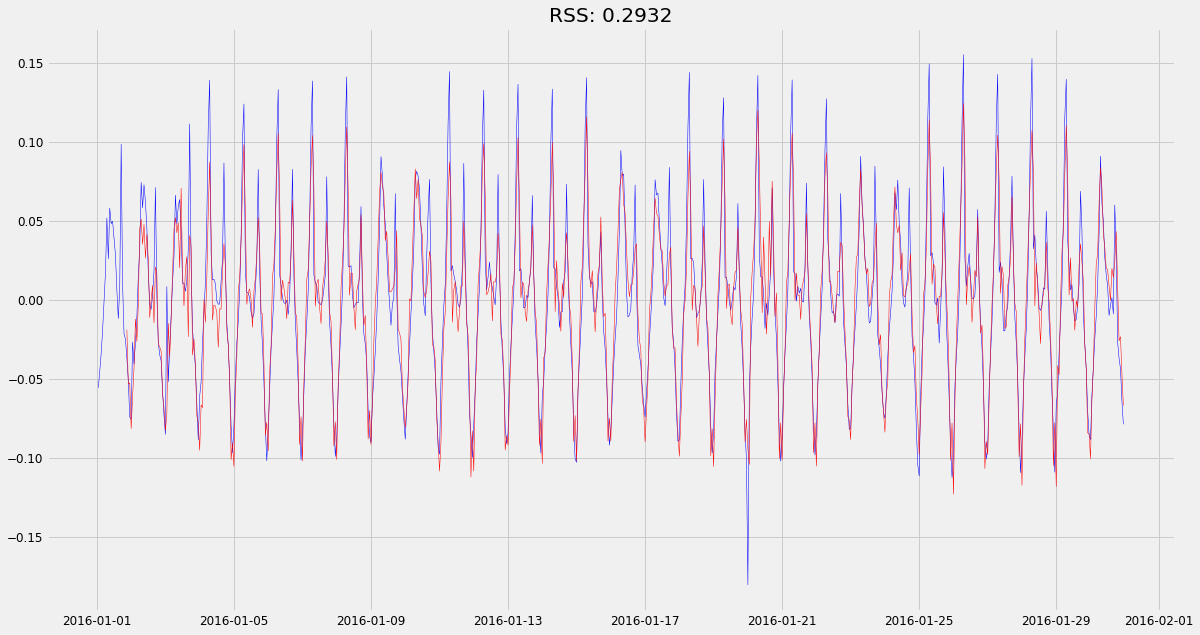

In [40]:
plt.plot(ts_log_diff, color='blue', linewidth = 0.5)
plt.plot(model_fit.fittedvalues, color='red', linewidth = 0.5)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

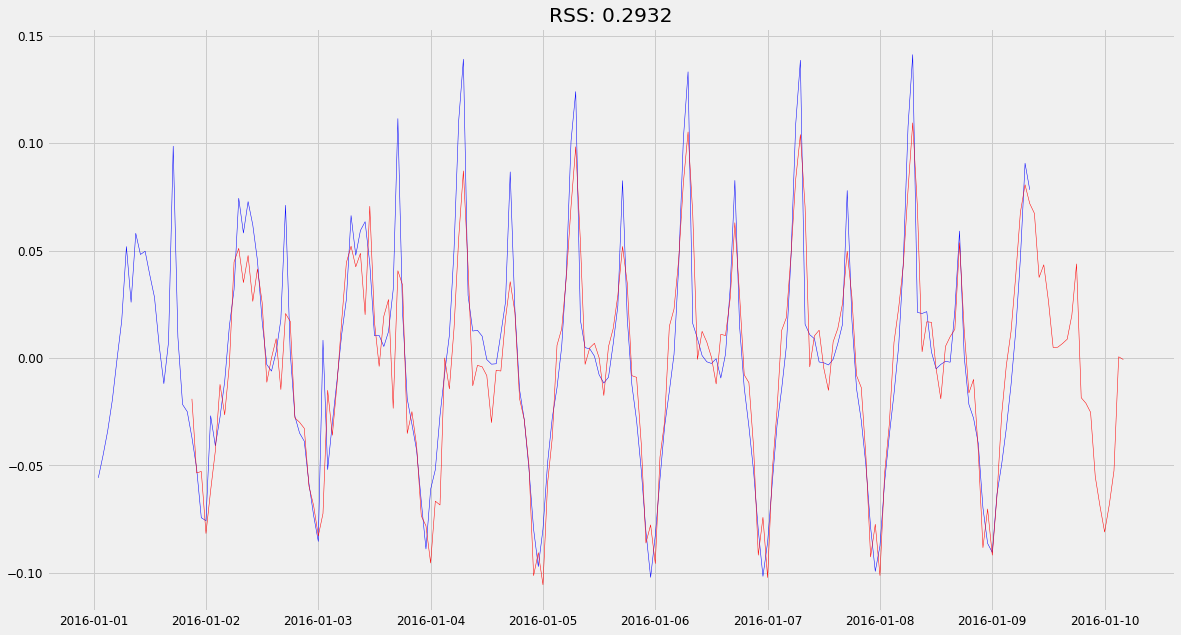

In [41]:
plt.plot(ts_log_diff[:200], color='blue', linewidth = 0.5)
plt.plot(model_fit.fittedvalues[:200], color='red', linewidth = 0.5)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))
plt.show()

### Reversing the transformations

__Fitted or predicted values:__

In [42]:
predictions_ARIMA_diff = pd.Series(model_fit.fittedvalues, copy=True)
print (predictions_ARIMA_diff.head())

time
2016-01-01 21:00:00   -0.019011
2016-01-01 22:00:00   -0.053454
2016-01-01 23:00:00   -0.052790
2016-01-02 00:00:00   -0.081635
2016-01-02 01:00:00   -0.061543
dtype: float64


__Cumulative Sum to reverse differencing:__

In [43]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

time
2016-01-01 21:00:00   -0.019011
2016-01-01 22:00:00   -0.072465
2016-01-01 23:00:00   -0.125256
2016-01-02 00:00:00   -0.206891
2016-01-02 01:00:00   -0.268434
dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [44]:
predictions_ARIMA_log = pd.Series(ts_log.hourly_load.iloc[0], index=ts_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head(40)

time
2016-01-01 00:00:00    14.086830
2016-01-01 01:00:00    14.086830
2016-01-01 02:00:00    14.086830
2016-01-01 03:00:00    14.086830
2016-01-01 04:00:00    14.086830
2016-01-01 05:00:00    14.086830
2016-01-01 06:00:00    14.086830
2016-01-01 07:00:00    14.086830
2016-01-01 08:00:00    14.086830
2016-01-01 09:00:00    14.086830
2016-01-01 10:00:00    14.086830
2016-01-01 11:00:00    14.086830
2016-01-01 12:00:00    14.086830
2016-01-01 13:00:00    14.086830
2016-01-01 14:00:00    14.086830
2016-01-01 15:00:00    14.086830
2016-01-01 16:00:00    14.086830
2016-01-01 17:00:00    14.086830
2016-01-01 18:00:00    14.086830
2016-01-01 19:00:00    14.086830
2016-01-01 20:00:00    14.086830
2016-01-01 21:00:00    14.067818
2016-01-01 22:00:00    14.014364
2016-01-01 23:00:00    13.961574
2016-01-02 00:00:00    13.879939
2016-01-02 01:00:00    13.818396
2016-01-02 02:00:00    13.775165
2016-01-02 03:00:00    13.762884
2016-01-02 04:00:00    13.736437
2016-01-02 05:00:00    13.733441
2016-

__Taking Exponent to reverse Log Transform:__

In [45]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

Text(0.5, 1.0, 'RMSE: 840936.2207')

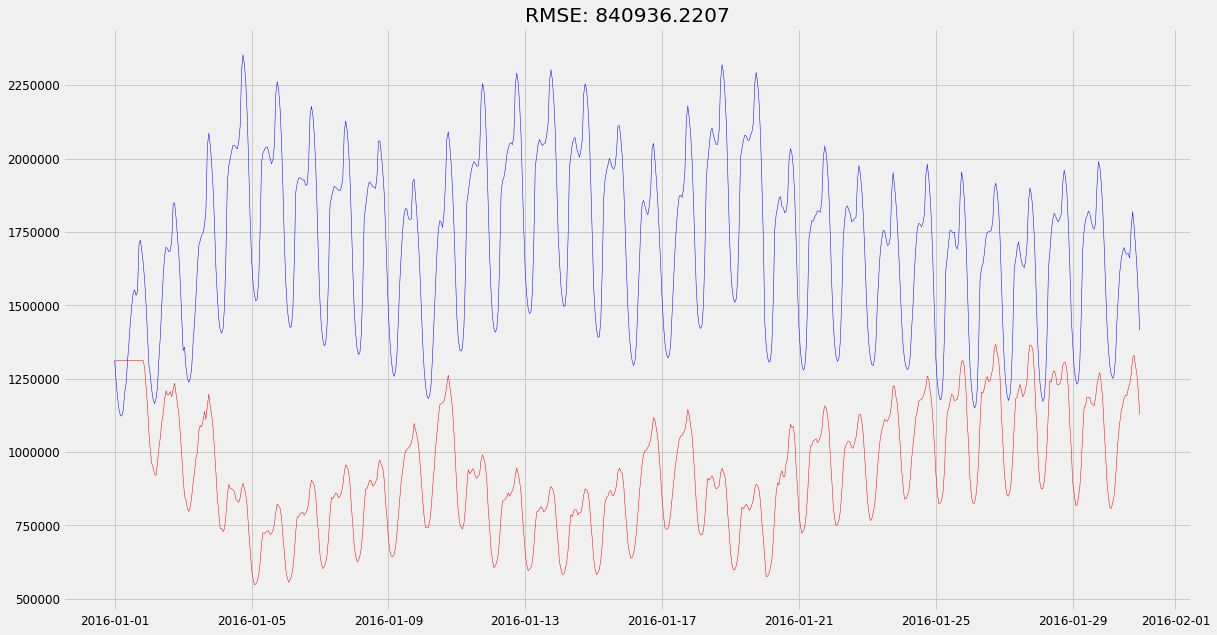

In [46]:
plt.plot(y.hourly_load, color='blue', linewidth = 0.5)
plt.plot(predictions_ARIMA, color='red', linewidth = 0.5)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.hourly_load)**2)/len(y.hourly_load)))

Text(0.5, 1.0, 'RMSE: 840936.2207')

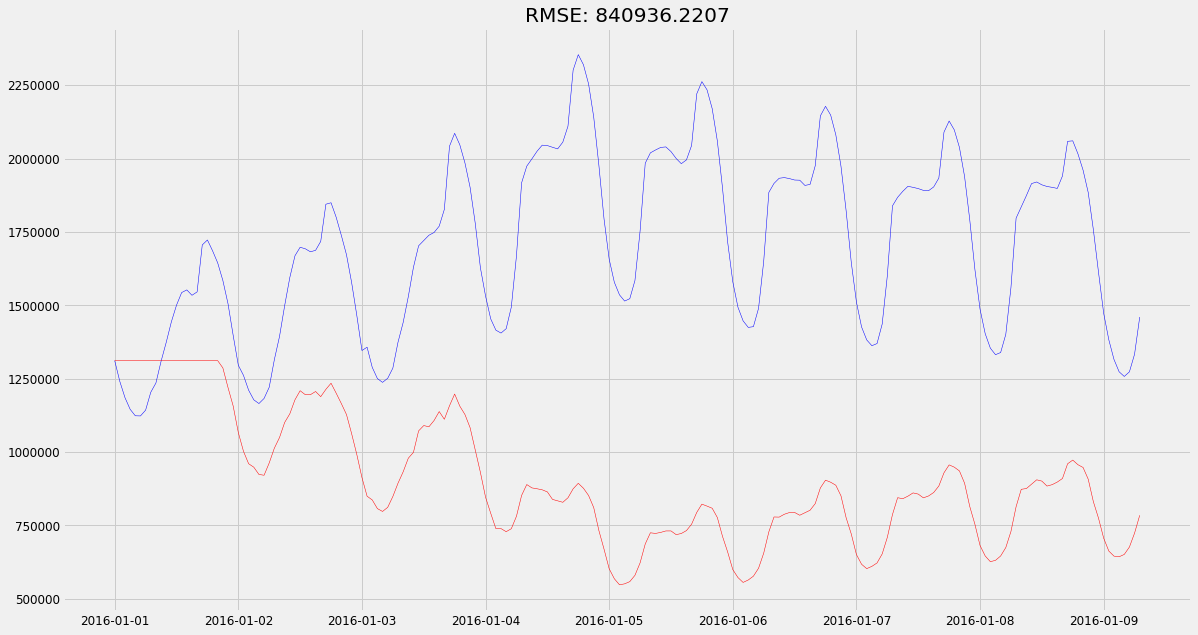

In [47]:
plt.plot(y.hourly_load[:200], color='blue', linewidth = 0.5)
plt.plot(predictions_ARIMA[:200], color='red', linewidth = 0.5)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA-y.hourly_load)**2)/len(y.hourly_load)))

### Forecast quality scoring metrics
- __R squared__
- __Mean Absolute Error__
- __Median Absolute Error__
- __Mean Squared Error__
- __Mean Squared Logarithmic Error__
- __Mean Absolute Percentage Error__

In [48]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, median_absolute_error, mean_squared_log_error

__R squared__, coefficient of determination (it can be interpreted as a percentage of variance explained by the model), (-inf, 1] 
- sklearn.metrics.r2_score

In [49]:
r2_score(y.hourly_load, predictions_ARIMA)

-7.636243598964265

__Mean Absolute Error__, it is an interpretable metric because it has the same unit of measurement as the initial series, [0, +inf)
- sklearn.metrics.mean_absolute_error

In [50]:
mean_absolute_error(y.hourly_load, predictions_ARIMA)

781858.1452790274

__Median Absolute Error__, again an interpretable metric, particularly interesting because it is robust to outliers, [0, +inf)
- sklearn.metrics.median_absolute_error

In [429]:
median_absolute_error(y.hourly_load, predictions_ARIMA)

762529.062667113

__Mean Squared Error__, most commonly used, gives higher penalty to big mistakes and vise versa, [0, +inf)
- sklearn.metrics.mean_squared_error


In [430]:
mean_squared_error(y.hourly_load, predictions_ARIMA)

707173727329.6904

__Mean Squared Logarithmic Error__, practically the same as MSE but we initially take logarithm of the series, as a result we give attention to small mistakes as well, usually is used when data has exponential trends, [0, +inf)
- sklearn.metrics.mean_squared_log_error

In [431]:
mean_squared_log_error(y.hourly_load, predictions_ARIMA)

0.4351636719308624

__Mean Absolute Percentage Error__, same as MAE but percentage, — very convenient when you want to explain the quality of the model to your management, [0, +inf), 
- not implemented in sklearn

In [432]:
def mean_absolute_percentage_error(y_true, y_pred): 
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [433]:
mean_absolute_percentage_error(y.hourly_load, predictions_ARIMA)

44.41448784496829

__Function to evaluate forecast using above metrics:__

In [51]:
def evaluate_forecast(y,pred):
    results = pd.DataFrame({'r2_score':r2_score(y, pred),
                           }, index=[0])
    results['mean_absolute_error'] = mean_absolute_error(y, pred)
    results['median_absolute_error'] = median_absolute_error(y, pred)
    results['mse'] = mean_squared_error(y, pred)
    results['msle'] = mean_squared_log_error(y, pred)
    results['mape'] = mean_absolute_percentage_error(y, pred)
    results['rmse'] = np.sqrt(results['mse'])
    return results

In [52]:
evaluate_forecast(y.hourly_load, predictions_ARIMA)

NameError: name 'mean_absolute_percentage_error' is not defined

- RMSE has the benefit of penalizing large errors more so can be more appropriate in some cases, for example, if being off by 10 is more than twice as bad as being off by 5. But if being off by 10 is just twice as bad as being off by 5, then MAE is more appropriate.

- From an interpretation standpoint, MAE is clearly the winner. RMSE does not describe average error alone and has other implications that are more difficult to tease out and understand.

- On the other hand, one distinct advantage of RMSE over MAE is that RMSE avoids the use of taking the absolute value, which is undesirable in many mathematical calculations

## Moving Average (MA)

- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [53]:
# MA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(0, 1))
model_fit = model.fit(disp=False)

In [54]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            hourly_load   No. Observations:                  719
Model:                     ARMA(0, 1)   Log Likelihood                1333.321
Method:                       css-mle   S.D. of innovations              0.038
Date:                Sun, 13 Oct 2019   AIC                          -2660.643
Time:                        18:38:00   BIC                          -2646.909
Sample:                    01-01-2016   HQIC                         -2655.340
                         - 01-30-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              3.155e-05      0.002      0.013      0.989      -0.005       0.005
ma.L1.hourly_load     0.6719      0.019     35.954      0.000       0.635       0.709
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
MA.1           -1.4883           +0.0000j            1.4883            0.5000
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 1.0318')

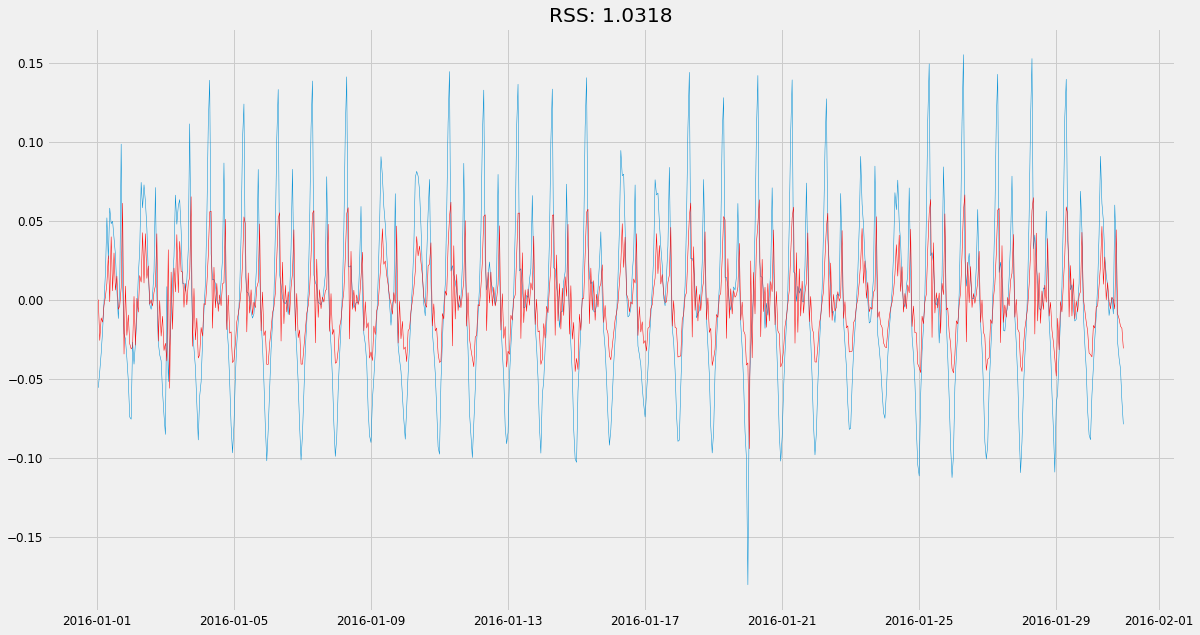

In [55]:
plt.plot(ts_log_diff, linewidth=0.5)
plt.plot(model_fit.fittedvalues, color='red', linewidth=0.5)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 1.0318')

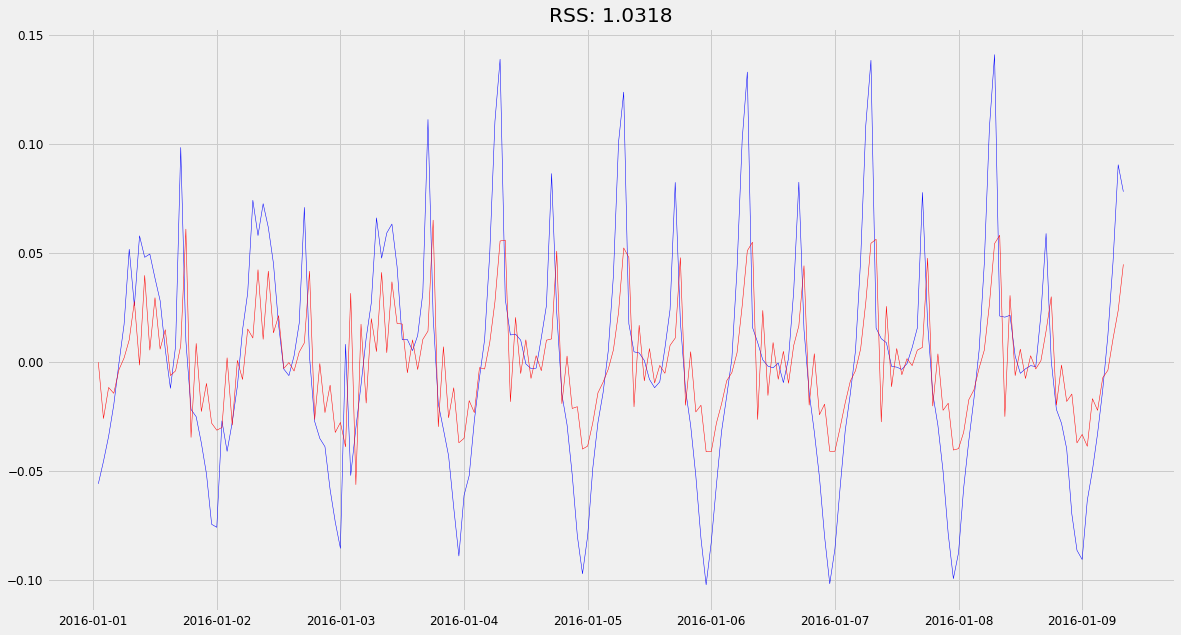

In [56]:
plt.plot(ts_log_diff[:200], color='blue', linewidth=0.5)
plt.plot(model_fit.fittedvalues[:200], color='red', linewidth=0.5)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Autoregressive Moving Average (ARMA)

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 


In [57]:
# ARMA example
from statsmodels.tsa.arima_model import ARMA
from random import random

# fit model
model = ARMA(ts_log_diff, order=(1, 2))
model_fit = model.fit(disp=False)

In [58]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            hourly_load   No. Observations:                  719
Model:                     ARMA(1, 2)   Log Likelihood                1466.862
Method:                       css-mle   S.D. of innovations              0.031
Date:                Sun, 13 Oct 2019   AIC                          -2923.724
Time:                        18:38:02   BIC                          -2900.835
Sample:                    01-01-2016   HQIC                         -2914.887
                         - 01-30-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const                -0.0003      0.005     -0.064      0.949      -0.009       0.009
ar.L1.hourly_load     0.6116      0.048     12.616      0.000       0.517       0.707
ma.L1.hourly_load     0.3856      0.057      6.745      0.000       0.274       0.498
ma.L2.hourly_load     0.1254      0.046      2.709      0.007       0.035       0.216
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.6351           +0.0000j            1.6351            0.0000
MA.1           -1.5369           -2.3686j            2.8235           -0.3416
MA.2           -1.5369           +2.3686j            2.8235            0.3416
-----------------------------------------------------------------------------
"""

Text(0.5, 1.0, 'RSS: 0.7124')

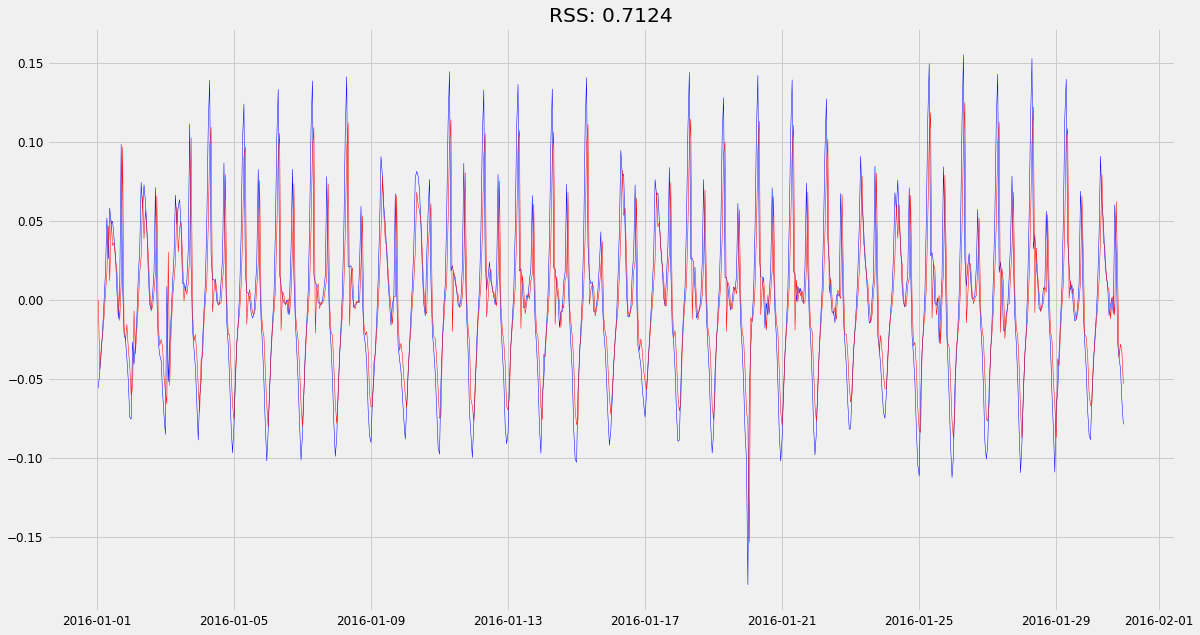

In [59]:
plt.plot(ts_log_diff, color='blue', linewidth=0.5)
plt.plot(model_fit.fittedvalues, color='red', linewidth=0.5)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

Text(0.5, 1.0, 'RSS: 0.7124')

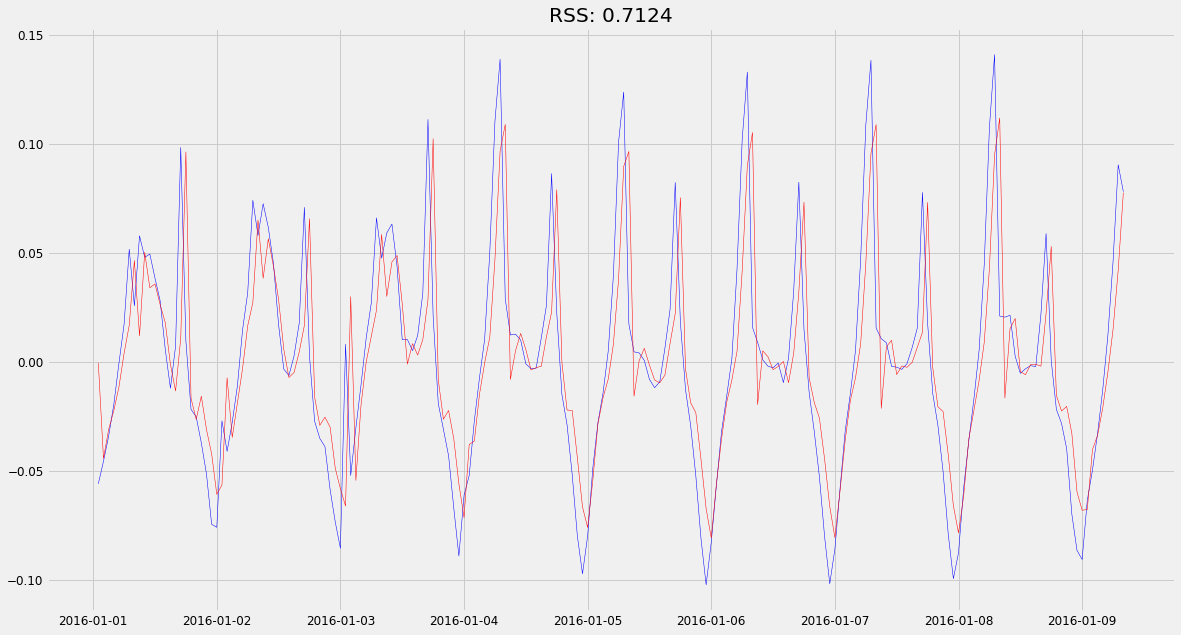

In [60]:
plt.plot(ts_log_diff[:200], color='blue', linewidth=0.5)
plt.plot(model_fit.fittedvalues[:200], color='red', linewidth=0.5)
plt.title('RSS: %.4f'% np.nansum((model_fit.fittedvalues-ts_log_diff)**2))

## Autoregressive Integrated Moving Average (ARIMA)
In an ARIMA model there are 3 parameters that are used to help model the major aspects of a times series: seasonality, trend, and noise. These parameters are labeled p,d,and q.

- __Number of AR (Auto-Regressive) terms (p):__ p is the parameter associated with the auto-regressive aspect of the model, which incorporates past values i.e lags of dependent variable. For instance if p is 5, the predictors for x(t) will be x(t-1)….x(t-5).
- __Number of Differences (d):__ d is the parameter associated with the integrated part of the model, which effects the amount of differencing to apply to a time series.
- __Number of MA (Moving Average) terms (q):__ q is size of the moving average part window of the model i.e. lagged forecast errors in prediction equation. For instance if q is 5, the predictors for x(t) will be e(t-1)….e(t-5) where e(i) is the difference between the moving average at ith instant and actual value. 

<br>__Observations from EDA on the time series:__
- Non stationarity implies at least one level of differencing (d) is required in ARIMA
- [The next step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively, using PACF, ACF plots](https://people.duke.edu/~rnau/411arim3.htm)

[Tuning ARIMA parameters](https://machinelearningmastery.com/tune-arima-parameters-python/)


Note: A problem with ARIMA is that it does not support seasonal data. That is a time series with a repeating cycle. ARIMA expects data that is either not seasonal or has the seasonal component removed, e.g. seasonally adjusted via methods such as seasonal differencing.

In [61]:
ts = y.hourly_load - y.hourly_load.shift()
ts.dropna(inplace=True)

__ACF and PACF plots after differencing:__
- Confidence intervals are drawn as a cone. 
- By default, this is set to a 95% confidence interval, suggesting that correlation values outside of this code are very likely a correlation and not a statistical fluke.
- AR(1) process -- has ACF tailing out and PACF cutting off at lag=1
- AR(2) process -- has ACF tailing out and PACF cutting off at lag=2
- MA(1) process -- has ACF cut off at lag=1
- MA(2) process -- has ACF cut off at lag=2

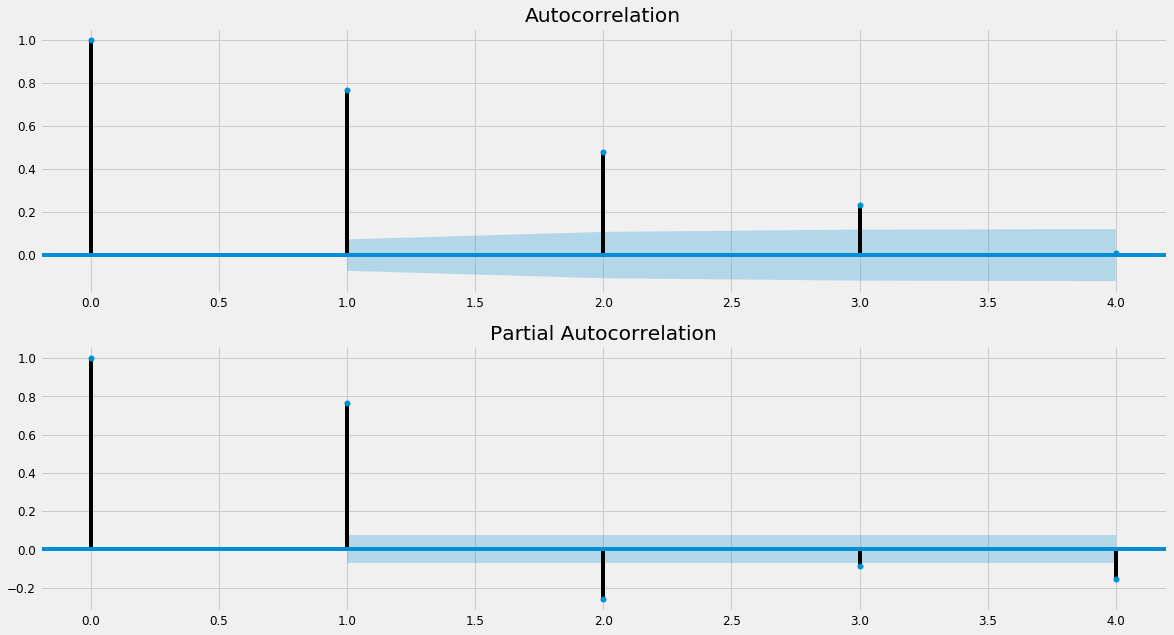

In [62]:
pyplot.figure()
pyplot.subplot(211)
plot_acf(ts, ax=pyplot.gca(),lags=4)
pyplot.subplot(212)
plot_pacf(ts, ax=pyplot.gca(),lags=4)
pyplot.show()

## Interpreting ACF plots


ACF Shape	| Indicated Model |
-- | -- |
Exponential, decaying to zero |	Autoregressive model. Use the partial autocorrelation plot to identify the order of the autoregressive model |
Alternating positive and negative, decaying to zero	Autoregressive model. |  Use the partial autocorrelation plot to help identify the order. |
One or more spikes, rest are essentially zero | Moving average model, order identified by where plot becomes zero. |
Decay, starting after a few lags |	Mixed autoregressive and moving average (ARMA) model. | 
All zero or close to zero | Data are essentially random. |
High values at fixed intervals | Include seasonal autoregressive term. |
No decay to zero |	Series is not stationary |

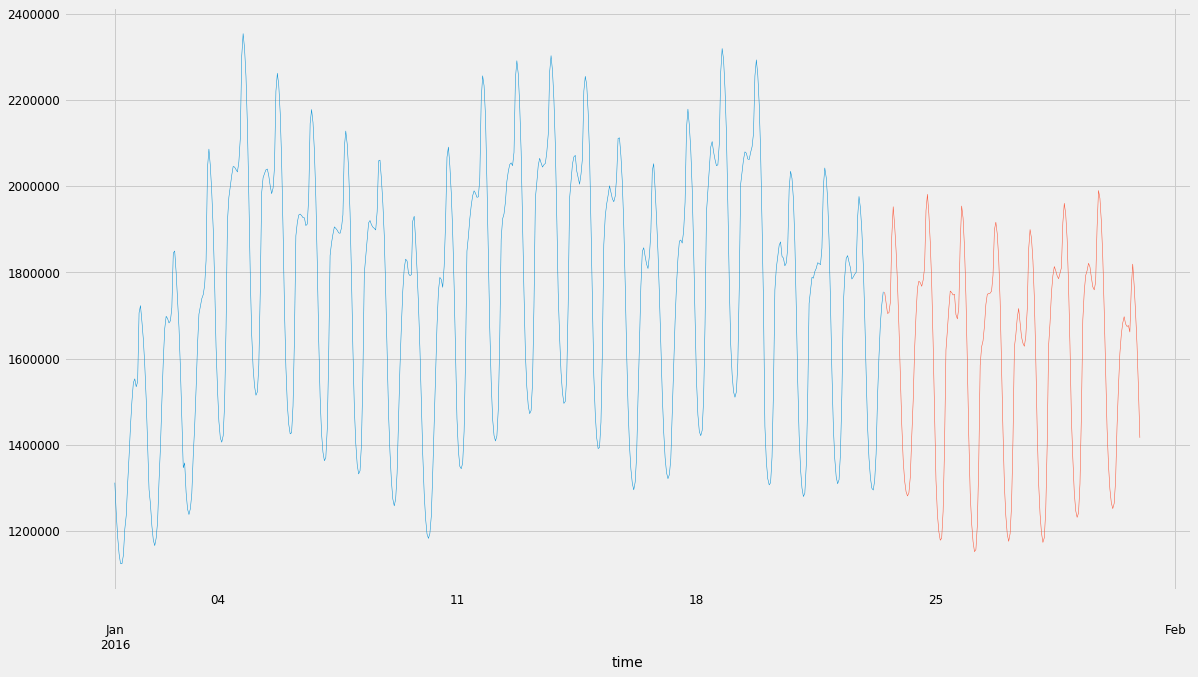

In [63]:
#divide into train and validation set
train = y[:int(0.75*(len(y)))]
valid = y[int(0.75*(len(y))):]

#plotting the data
train['hourly_load'].plot(linewidth=0.5)
valid['hourly_load'].plot(linewidth=0.5)

In [64]:
# ARIMA example
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt

# fit model
model = ARIMA(train, order=(2, 0, 3))
model_fit = model.fit(disp=1)

In [65]:
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                              ARMA Model Results                              
==============================================================================
Dep. Variable:            hourly_load   No. Observations:                  540
Model:                     ARMA(2, 3)   Log Likelihood               -6632.664
Method:                       css-mle   S.D. of innovations          52030.544
Date:                Sun, 13 Oct 2019   AIC                          13279.329
Time:                        18:38:10   BIC                          13309.369
Sample:                    01-01-2016   HQIC                         13291.077
                         - 01-23-2016                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
const              1.753e+06   2.69e+04     65.163      0.000     1.7e+06    1.81e+06
ar.L1.hourly_load     1.7124      0.043     39.781      0.000       1.628       1.797
ar.L2.hourly_load    -0.7965      0.040    -20.120      0.000      -0.874      -0.719
ma.L1.hourly_load     0.0795      0.059      1.340      0.181      -0.037       0.196
ma.L2.hourly_load    -0.0529      0.054     -0.978      0.329      -0.159       0.053
ma.L3.hourly_load    -0.0134      0.052     -0.259      0.796      -0.115       0.088
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            1.0749           -0.3163j            1.1205           -0.0455
AR.2            1.0749           +0.3163j            1.1205            0.0455
MA.1            3.5680           -0.0000j            3.5680           -0.0000
MA.2           -3.7542           -2.6026j            4.5681           -0.4035
MA.3           -3.7542           +2.6026j            4.5681            0.4035
-----------------------------------------------------------------------------
"""

In [66]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index, dynamic=True)

In [67]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 275206.7542803598, MSE:75738757601.53033


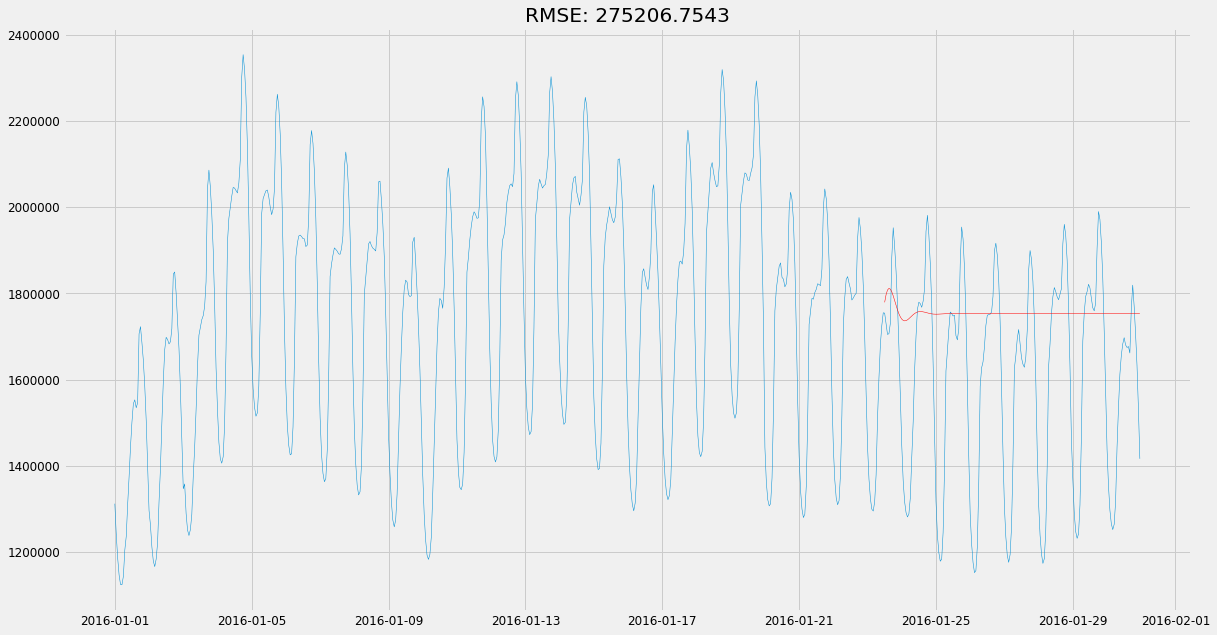

In [68]:
plt.plot(y.hourly_load, linewidth=0.5)
plt.plot(predictions, color='red', linewidth=0.5)
plt.title('RMSE: %.4f'% rmse)
plt.show()

__Fitted or predicted values:__

In [308]:
predictions_ARIMA_diff = pd.Series(predictions, copy=True)
print (predictions_ARIMA_diff.head())

2016-06-08 18:00:00    1.379648e+06
2016-06-08 19:00:00    1.373683e+06
2016-06-08 20:00:00    1.393026e+06
2016-06-08 21:00:00    1.393733e+06
2016-06-08 22:00:00    1.372772e+06
Freq: H, dtype: float64


__Cumulative Sum to reverse differencing:__

In [309]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
print (predictions_ARIMA_diff_cumsum.head())

2016-06-08 18:00:00    1.379648e+06
2016-06-08 19:00:00    2.753331e+06
2016-06-08 20:00:00    4.146357e+06
2016-06-08 21:00:00    5.540089e+06
2016-06-08 22:00:00    6.912861e+06
Freq: H, dtype: float64


__Adding 1st month value which was previously removed while differencing:__

In [310]:
predictions_ARIMA_log = pd.Series(valid.hourly_load.iloc[0], index=valid.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,fill_value=0)
predictions_ARIMA_log.head()

time
2016-06-08 18:00:00    2.754962e+06
2016-06-08 19:00:00    4.128645e+06
2016-06-08 20:00:00    5.521671e+06
2016-06-08 21:00:00    6.915404e+06
2016-06-08 22:00:00    8.288176e+06
dtype: float64

__Taking Exponent to reverse Log Transform:__

Text(0.5, 1.0, 'RMSE: 510296029.3806')

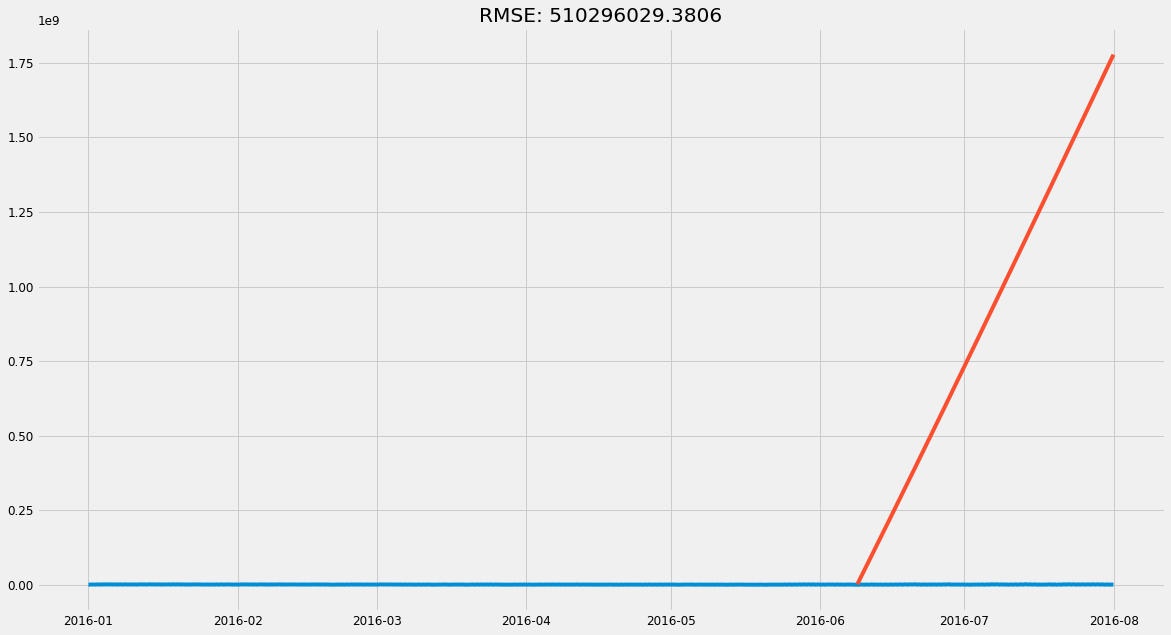

In [314]:
plt.plot(y.hourly_load)
plt.plot(predictions_ARIMA_log)
plt.title('RMSE: %.4f'% np.sqrt(np.nansum((predictions_ARIMA_log-ts)**2)/len(ts)))

In [315]:
evaluate_forecast(y[start_index:end_index], predictions_ARIMA_log)

r2_score  mean_absolute_error  median_absolute_error           mse       msle  mape          rmse
0 -6.934154e+06         8.804633e+08           8.763522e+08  1.038565e+18  37.748549   NaN  1.019100e+09

### Auto ARIMA

In [87]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, seasonal_order=(1, 1, 1, 12), error_action='ignore', suppress_warnings=True)
model.fit(train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=13277.437, BIC=13303.186, Fit time=0.223 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=15128.824, BIC=15137.407, Fit time=0.019 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 1); AIC=13846.553, BIC=13859.427, Fit time=0.037 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=14749.845, BIC=14762.720, Fit time=0.079 seconds
Fit ARIMA: order=(1, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=13395.339, BIC=13416.797, Fit time=0.136 seconds
Fit ARIMA: order=(3, 0, 2) seasonal_order=(0, 0, 0, 1); AIC=13279.391, BIC=13309.432, Fit time=0.411 seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=13276.983, BIC=13298.441, Fit time=0.122 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=13528.544, BIC=13545.710, Fit time=0.127 seconds
Fit ARIMA: order=(3, 0, 1) seasonal_order=(0, 0, 0, 1); AIC=13278.636, BIC=13304.385, Fit time=0.287 seconds
Fit ARIMA: order=(2

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(2, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(0, 0, 0, 1), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

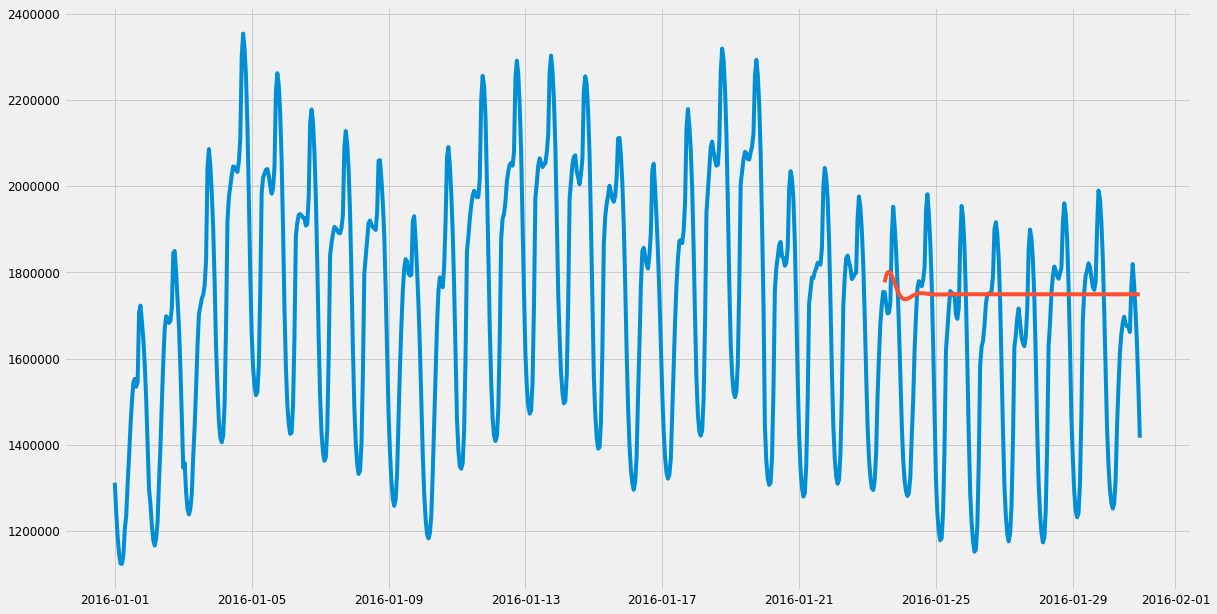

In [88]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.hourly_load, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [86]:
evaluate_forecast(valid, forecast)

NameError: name 'mean_absolute_percentage_error' is not defined

## Seasonal Autoregressive Integrated Moving-Average (SARIMA)
Seasonal Autoregressive Integrated Moving Average, SARIMA or Seasonal ARIMA, is an extension of ARIMA that explicitly supports univariate time series data with a seasonal component.

It adds three new hyperparameters to specify the autoregression (AR), differencing (I) and moving average (MA) for the seasonal component of the series, as well as an additional parameter for the period of the seasonality.

__Trend Elements:__

There are three trend elements that require configuration. They are the same as the ARIMA model, specifically:

- p: Trend autoregression order.
- d: Trend difference order.
- q: Trend moving average order.

__Seasonal Elements:__

There are four seasonal elements that are not part of ARIMA that must be configured; they are:

- P: Seasonal autoregressive order.
- D: Seasonal difference order.
- Q: Seasonal moving average order.
- m: The number of time steps for a single seasonal period. For example, an S of 12 for monthly data suggests a yearly seasonal cycle.

__SARIMA notation:__
SARIMA(p,d,q)(P,D,Q,m)

In [547]:
# SARIMA example
from statsmodels.tsa.statespace.sarimax import SARIMAX

# fit model
model = SARIMAX(train, order=(2, 0, 4), seasonal_order=(1, 1, 1, 1))
model_fit = model.fit(disp=False)

In [548]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
predictions = model_fit.predict(start=start_index, end=end_index)

In [549]:
# report performance
mse = mean_squared_error(y[start_index:end_index], predictions)
rmse = sqrt(mse)
print('RMSE: {}, MSE:{}'.format(rmse,mse))

RMSE: 312809.63652555295, MSE:97849868703.24857


Text(0.5, 1.0, 'RMSE: 312809.6365')

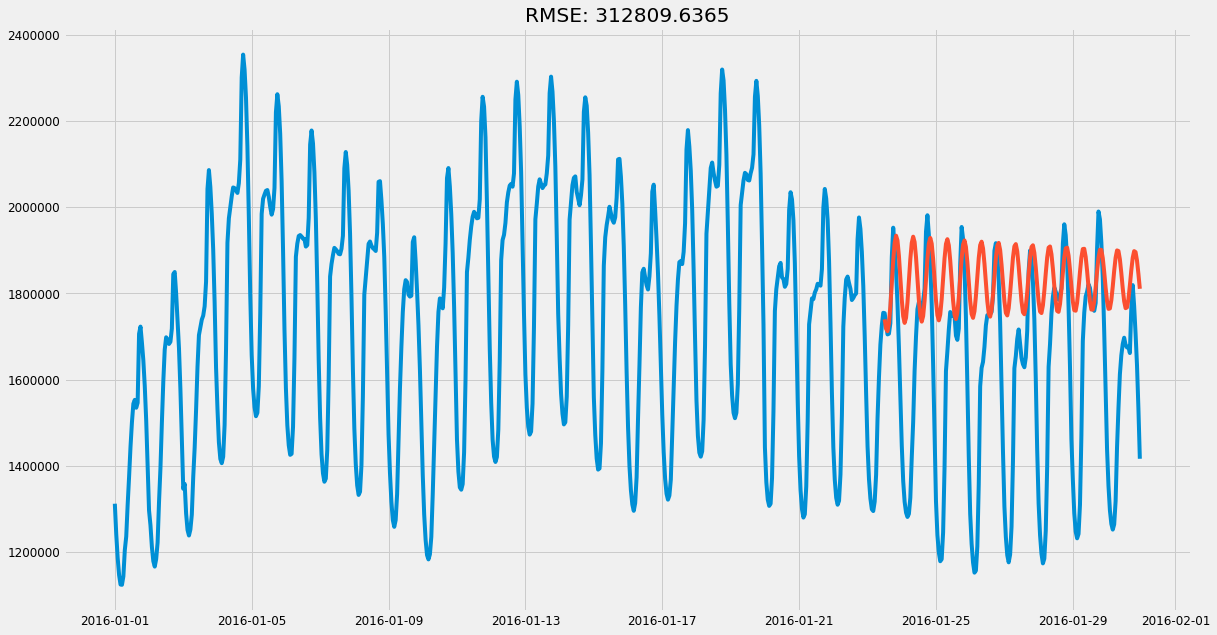

In [550]:
plt.plot(y)
plt.plot(predictions)
plt.title('RMSE: %.4f'% rmse)

In [551]:
evaluate_forecast(y[start_index:end_index], predictions)

r2_score  mean_absolute_error  median_absolute_error           mse      msle  mape           rmse
0 -0.751392        236336.420481          155757.392512  9.784987e+10  0.040755   NaN  312809.636526

### Auto - SARIMA

[auto_arima documentation for selecting best model](https://www.alkaline-ml.com/pmdarima/tips_and_tricks.html)

In [89]:
#building the model
from pyramid.arima import auto_arima
model = auto_arima(train, trace=True, error_action='ignore', suppress_warnings=True, seasonal=True, m=24, stepwise=True)
model.fit(train)

Fit ARIMA: order=(2, 0, 2) seasonal_order=(1, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 24); AIC=15128.824, BIC=15137.407, Fit time=0.014 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 0, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(1, 0, 1, 24); AIC=14829.908, BIC=14847.074, Fit time=1.235 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 24); AIC=13440.540, BIC=13461.998, Fit time=1.778 seconds
Fit ARIMA: order=(1, 0, 1) seasonal_order=(1, 0, 1, 24); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(2, 0, 1) seasonal_order=(1, 0, 1, 24); AIC=12971.807, BIC=13001.848, Fit tim

ARIMA(callback=None, disp=0, maxiter=50, method=None, order=(3, 0, 1),
   out_of_sample_size=0, scoring='mse', scoring_args={},
   seasonal_order=(2, 0, 2, 24), solver='lbfgs', start_params=None,
   suppress_warnings=True, transparams=True, trend='c')

In [90]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = model.predict()

In [91]:
pred = model.predict(n_periods=len(valid))
pred = pd.DataFrame(pred,index = valid.index,columns=['Prediction'])

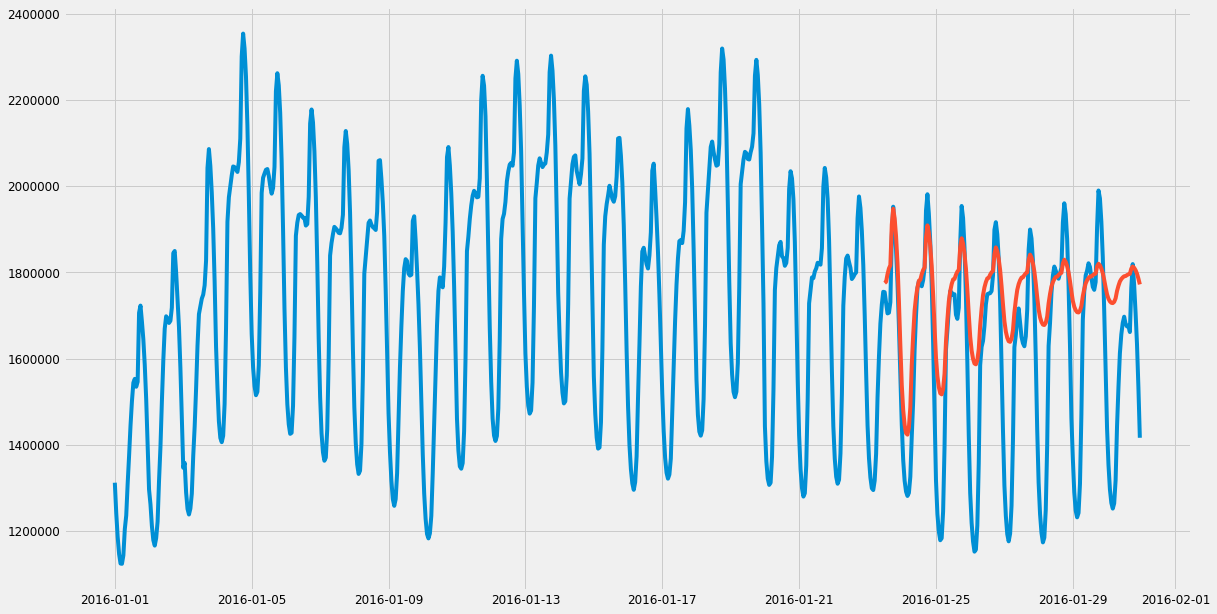

In [92]:
forecast = model.predict(n_periods=len(valid))
forecast = pd.DataFrame(forecast,index = valid.index,columns=['Prediction'])

#plot the predictions for validation set
plt.plot(y.hourly_load, label='Train')
#plt.plot(valid, label='Valid')
plt.plot(forecast, label='Prediction')
plt.show()

In [1109]:
evaluate_forecast(y[start_index:end_index], forecast)

r2_score  mean_absolute_error  median_absolute_error          mse      msle  mape       rmse
0  0.750988            31.117199              26.022291  1523.531223  0.007953   NaN  39.032438

### Tuned SARIMA

In [1110]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 6) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 6)
SARIMAX: (0, 0, 1) x (0, 1, 0, 6)
SARIMAX: (0, 1, 0) x (0, 1, 1, 6)
SARIMAX: (0, 1, 0) x (1, 0, 0, 6)


In [1111]:
min_aic = 999999999
for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(train,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)
            
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            
            #Check for best model with lowest AIC
            if results.aic < min_aic:
                min_aic = results.aic
                min_aic_model = results
        except:
            continue


ARIMA(0, 0, 0)x(0, 0, 0, 6)12 - AIC:1484.6772209911371
ARIMA(0, 0, 0)x(0, 0, 1, 6)12 - AIC:1332.70817170708
ARIMA(0, 0, 0)x(0, 1, 0, 6)12 - AIC:1106.9983169558561
ARIMA(0, 0, 0)x(0, 1, 1, 6)12 - AIC:1015.2677070067782
ARIMA(0, 0, 0)x(1, 0, 0, 6)12 - AIC:1115.9461051704866
ARIMA(0, 0, 0)x(1, 0, 1, 6)12 - AIC:1001.4755946445601
ARIMA(0, 0, 0)x(1, 1, 0, 6)12 - AIC:951.0958895418044
ARIMA(0, 0, 0)x(1, 1, 1, 6)12 - AIC:860.255589360235
ARIMA(0, 0, 1)x(0, 0, 0, 6)12 - AIC:1334.2309362006272
ARIMA(0, 0, 1)x(0, 0, 1, 6)12 - AIC:1194.12573571134
ARIMA(0, 0, 1)x(0, 1, 0, 6)12 - AIC:998.4912121256906
ARIMA(0, 0, 1)x(0, 1, 1, 6)12 - AIC:912.878068945886
ARIMA(0, 0, 1)x(1, 0, 0, 6)12 - AIC:1018.9733569352445
ARIMA(0, 0, 1)x(1, 0, 1, 6)12 - AIC:914.9884746085561
ARIMA(0, 0, 1)x(1, 1, 0, 6)12 - AIC:866.3727396781308
ARIMA(0, 0, 1)x(1, 1, 1, 6)12 - AIC:792.5520247091739
ARIMA(0, 1, 0)x(0, 0, 0, 6)12 - AIC:993.1312724630138
ARIMA(0, 1, 0)x(0, 0, 1, 6)12 - AIC:943.9245123025381
ARIMA(0, 1, 0)x(0, 1, 0, 

In [1112]:
min_aic_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 Statespace Model Results                                
=========================================================================================
Dep. Variable:                        passengers   No. Observations:                  108
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 6)   Log Likelihood                -337.236
Date:                           Tue, 11 Dec 2018   AIC                            682.471
Time:                                   14:19:43   BIC                            692.602
Sample:                               01-01-1949   HQIC                           686.562
                                    - 12-01-1957                                         
Covariance Type:                             opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.4552      0.082     -5.543      0.000      -0.616      -0.294
ar.S.L6       -1.0894      0.017    -65.219      0.000      -1.122      -1.057
ma.S.L6        2.2735      0.600      3.792      0.000       1.098       3.449
sigma2        15.8272      7.949      1.991      0.046       0.248      31.406
===================================================================================
Ljung-Box (Q):                       45.44   Jarque-Bera (JB):                 2.17
Prob(Q):                              0.26   Prob(JB):                         0.34
Heteroskedasticity (H):               0.61   Skew:                             0.37
Prob(H) (two-sided):                  0.17   Kurtosis:                         2.99
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [79]:
start_index = valid.index.min()
end_index = valid.index.max()

#Predictions
pred = min_aic_model.get_prediction(start=start_index,end=end_index, dynamic=False)

NameError: name 'min_aic_model' is not defined

In [264]:
pred_ci = pred.conf_int()
ax = y['1949':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('hourly_load')
plt.legend()
plt.show()

NameError: name 'pred' is not defined

__Model diagnostics:__
- Our primary concern is to ensure that the residuals of our model are uncorrelated and normally distributed with zero-mean. 
- If the seasonal ARIMA model does not satisfy these properties, it is a good indication that it can be further improved.

The model diagnostic suggests that the model residual is normally distributed based on the following:

- In the top right plot, the red KDE line follows closely with the N(0,1) line. Where, N(0,1) is the standard notation for a normal distribution with mean 0 and standard deviation of 1. This is a good indication that the residuals are normally distributed. 
- The qq-plot on the bottom left shows that the ordered distribution of residuals (blue dots) follows the linear trend of the samples taken from a standard normal distribution. Again, this is a strong indication that the residuals are normally distributed.
- The residuals over time (top left plot) don't display any obvious seasonality and appear to be white noise. 
- This is confirmed by the autocorrelation (i.e. correlogram) plot on the bottom right, which shows that the time series residuals have low correlation with lagged versions of itself.

In [200]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()

NameError: name 'results' is not defined

In [1116]:
y_forecasted = pred.predicted_mean.values
y_truth = y[start_index:end_index].passengers.values
mse = ((y_forecasted - y_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

The Mean Squared Error of our forecasts is 781.5


In [1117]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

The Root Mean Squared Error of our forecasts is 27.96


In [1118]:
evaluate_forecast(y_truth, y_forecasted)

r2_score  mean_absolute_error  median_absolute_error        mse      msle      mape       rmse
0  0.872268            24.733402              26.185186  781.50462  0.004216  5.932291  27.955404

## SARIMAX
- The implementation is called SARIMAX instead of SARIMA because the “X” addition to the method name means that the implementation also supports exogenous variables.
- Exogenous variables are optional can be specified via the “exog” argument.
 - model = SARIMAX(data, exog=other_data, ...)
- Examples of exogenous variables: Population, holidays, number of airline companies, major events

## Prophet
- [Prophet](https://facebook.github.io/prophet/) is open source software released by Facebook's Core Data Science team.
- Prophet is a procedure for forecasting time series data based on an additive/multiplicative model where non-linear trends are fit with yearly, weekly, and daily seasonality, plus holiday effects. 
- It works best with time series that have strong seasonal effects and several seasons of historical data. 
- Prophet is robust to missing data and shifts in the trend, and typically handles outliers well.
- The Prophet package provides intuitive parameters which are easy to tune. 

[Prophet example notebooks](https://github.com/facebook/prophet/tree/master/notebooks)

__Trend parameters__

- growth: 'linear' or 'logistic' to specify a linear or logistic trend
- changepoints:	List of dates at which to include potential changepoints (automatic if not specified)
- n_changepoints: If changepoints in not supplied, you may provide the number of changepoints to be automatically included
- changepoint_prior_scale: Parameter for changing flexibility of automatic changepoint selection
 

__Seasonality and Holiday Parameters__

- yearly_seasonality: Fit yearly seasonality
- weekly_seasonality: Fit weekly seasonality
- daily_seasonality: Fit daily seasonality
- holidays: Feed dataframe containing holiday name and date
- seasonality_prior_scale: Parameter for changing strength of seasonality model
- holiday_prior_scale: Parameter for changing strength of holiday model

Prophet requires the variable names in the time series to be:

- y – Target
- ds – Datetime

In [94]:
train.head()

hourly_load
time                            
2016-01-01 00:00:00   1311693.43
2016-01-01 01:00:00   1240583.19
2016-01-01 02:00:00   1185502.49
2016-01-01 03:00:00   1145963.66
2016-01-01 04:00:00   1123874.26

In [95]:
train_prophet = pd.DataFrame()
train_prophet['ds'] = train.index
train_prophet['y'] = train.hourly_load.values

In [96]:
train_prophet.head()

ds           y
0 2016-01-01 00:00:00  1311693.43
1 2016-01-01 01:00:00  1240583.19
2 2016-01-01 02:00:00  1185502.49
3 2016-01-01 03:00:00  1145963.66
4 2016-01-01 04:00:00  1123874.26

In [97]:
from fbprophet import Prophet

#instantiate Prophet with only yearly seasonality as our data is monthly 
model = Prophet( yearly_seasonality=True, seasonality_mode = 'multiplicative')
model.fit(train_prophet) #fit the model with your dataframe

In [98]:
# predict for five months in the furure and MS - month start is the frequency
future = model.make_future_dataframe(periods = 36, freq = 'MS') 
future.tail()

ds
571 2018-09-01 11:00:00
572 2018-10-01 11:00:00
573 2018-11-01 11:00:00
574 2018-12-01 11:00:00
575 2019-01-01 11:00:00

In [99]:
forecast.columns

Index(['Prediction'], dtype='object')

In [100]:

# now lets make the forecasts
forecast = model.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()


ds          yhat    yhat_lower    yhat_upper
571 2018-09-01 11:00:00 -6.829671e+06 -1.854621e+08  1.711608e+08
572 2018-10-01 11:00:00 -1.026220e+07 -2.794462e+08  2.605110e+08
573 2018-11-01 11:00:00 -2.500805e+06 -6.865539e+07  6.449847e+07
574 2018-12-01 11:00:00  9.828105e+06 -2.553516e+08  2.713049e+08
575 2019-01-01 11:00:00 -6.290107e+07 -1.757338e+09  1.657266e+09

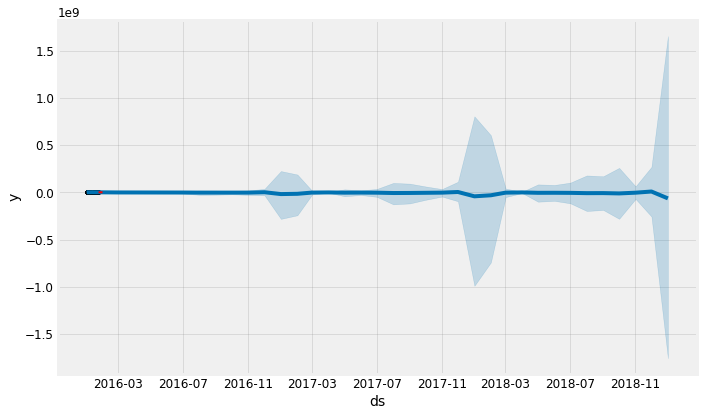

In [101]:
fig = model.plot(forecast)
#plot the predictions for validation set

plt.plot(valid, label='Valid', color = 'red', linewidth = 2)

plt.show()

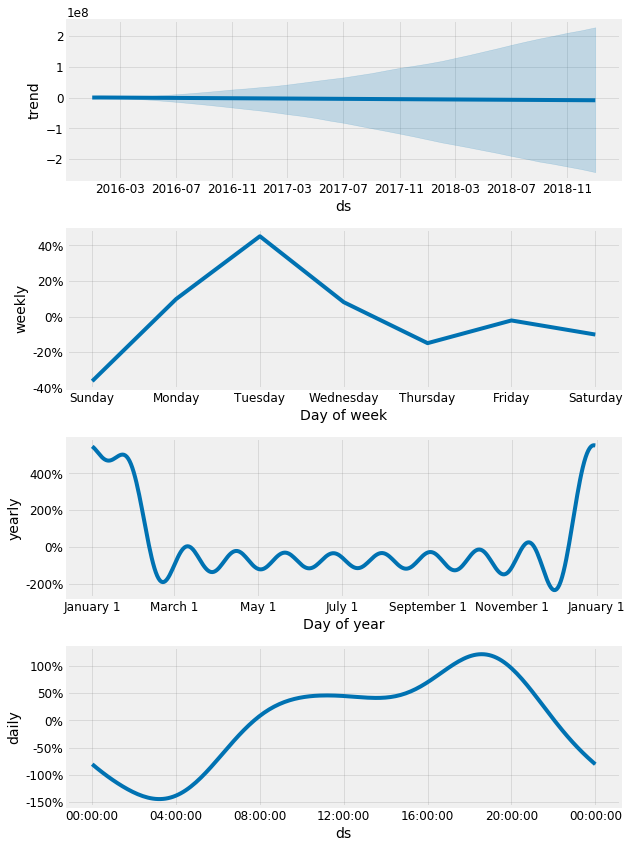

In [102]:
model.plot_components(forecast);

In [104]:
y_prophet = pd.DataFrame()
y_prophet['ds'] = y.index
y_prophet['y'] = y.hourly_load.values

In [105]:
y_prophet = y_prophet.set_index('ds')
forecast_prophet = forecast.set_index('ds')

In [107]:
evaluate_forecast(y_prophet.y[start_index:end_index], forecast_prophet.yhat[start_index:end_index])

ValueError: Found input variables with inconsistent numbers of samples: [180, 0]

## Improving Time Series Forecast models

1. Hyperparamter Optimization: Finding the optimal parameters of ARIMA/Prophet models.

2. Exogenous variables (SARIMAX): Including external variables like campaigns, holidays, events, natural calamities etc.

3. [Combining models for advanced time series predictions](https://www.kdnuggets.com/2016/11/combining-different-methods-create-advanced-time-series-prediction.html)

4. [Long Short Term Memory Network (LSTM)](https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/)

## Solve a problem!

__Store Item Demand Forecasting Challenge: https://www.kaggle.com/c/demand-forecasting-kernels-only__
- This competition is provided as a way to explore different time series techniques on a relatively simple and clean dataset.
- You are given 5 years of store-item sales data, and asked to predict 3 months of sales for 50 different items at 10 different stores.
- What's the best way to deal with seasonality? Should stores be modeled separately, or can you pool them together? Does deep learning work better than ARIMA? Can either beat xgboost?